In [1]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import math
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
import tensorflow as tf
np.random.seed(42)
tf.random.set_seed(42)
IMAGE_SIZE = 256
EPOCHS = 30
BATCH = 10
LR = 1e-4
PATH = "/Users/shirleychen/Documents/Fall2022/CS229/dataset2/model/"
IMAGE = "masked/masked_final_row_med_sat_damage/*"
OUT = IMAGE
# OUT = "masked/masked_final_gaussian_clump_dead_damage/*"


2022-12-08 19:21:51.512717: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "maskedlabels/*")))
    total_size = len(images)
    print(total_size)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)
    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)
    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)
    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)
def load_data2(path):
    images = sorted(glob(os.path.join(path, IMAGE)))
    masks = sorted(glob(os.path.join(path, "test_selected_labels/*")))
    return images,masks
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x
def read_image2(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x
def read_mask2(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y
    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y
def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)   
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    model = Model(inputs, x)
    return model
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)
def pixel_accuracy(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    z = y_true == y_pred
    z_tot = np.sum(z)
    per = z_tot/len(y_true)
    return per
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]

2022-12-08 19:21:59.906862: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x
def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [4]:
# (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

# print("Training data: ", len(train_x))
# print("Validation data: ", len(valid_x))
# print("Testing data: ", len(test_x))

In [5]:
model_bedrock = model()
model_bedrock.load_weights('./CNN_model_bedrock')
model_bedrock.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model_sand = model()
model_sand.load_weights('./CNN_model_sand')
model_sand.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model_soil = model()
model_soil.load_weights('./CNN_model_soil')
model_soil.compile(loss=dice_loss, optimizer=opt, metrics=metrics)
model_bigrock = model()
model_bigrock.load_weights('./CNN_model_bigrock')
model_bigrock.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [6]:
def fixup(y):
    y_fix = y*255
    y_fix[(y_fix > 16) * (y_fix <= 56)] = 32
    y_fix[(y_fix > 56) * (y_fix <= 80)] = 64
    y_fix[(y_fix > 80) * (y_fix <= 104)] = 96
    a = (y_fix > 104) * (y_fix <= 196)
    a = np.reshape(a,[256,256])
    y_fix[(y_fix > 104) * (y_fix <= 196)] = 128
    y_fix[y_fix > 196] = 255
    y_fix = y_fix/255
    y_fix = np.repeat(y_fix, 3, axis=2)
    return y_fix, a
def minifix(y_pred):
    a = y_pred < 0.5
    y_pred[y_pred >=  0.5] = 0
    y_pred[a] = 1
    y_pred = np.reshape(y_pred,[IMAGE_SIZE,IMAGE_SIZE,1])
    return y_pred
def multipred(x):
    y_pred_sand = model_sand.predict(np.expand_dims(x, axis=0))
    y_pred_bedrock = model_bedrock.predict(np.expand_dims(x, axis=0))
    y_pred_soil = model_soil.predict(np.expand_dims(x, axis=0))
    y_pred_bigrock = model_bigrock.predict(np.expand_dims(x, axis=0))
    y_pred_sand = minifix(y_pred_sand)*64
    y_pred_bedrock = minifix(y_pred_bedrock)*32
    y_pred_soil = minifix(y_pred_soil)
    y_pred_bigrock = minifix(y_pred_bigrock)*96
    y_pred_tot = np.ones((IMAGE_SIZE, IMAGE_SIZE, 1))*255
    for i in range(IMAGE_SIZE):
        for j in range(IMAGE_SIZE):
            if y_pred_sand[i,j] == 0 and y_pred_bedrock[i,j] == 32 and y_pred_soil[i,j] == 1 and y_pred_bigrock[i,j] == 96:
                y_pred_tot[i,j] = 64
            if y_pred_sand[i,j] == 64 and y_pred_bedrock[i,j] == 0 and y_pred_soil[i,j] == 1 and y_pred_bigrock[i,j] == 96:
                y_pred_tot[i,j] = 32
            if y_pred_sand[i,j] == 64 and y_pred_bedrock[i,j] == 32 and y_pred_soil[i,j] == 0 and y_pred_bigrock[i,j] == 96:
                y_pred_tot[i,j] = 0
            if y_pred_sand[i,j] == 64 and y_pred_bedrock[i,j] == 32 and y_pred_soil[i,j] == 1 and y_pred_bigrock[i,j] == 0:
                y_pred_tot[i,j] = 96
    y_pred_tot = y_pred_tot/255
    y_pred_tot = np.repeat(y_pred_tot, 3, axis = 2)
    return y_pred_tot
def to_rgb(x):
    y = np.ones((IMAGE_SIZE,IMAGE_SIZE,3))*255
    x = x*255
    for i in range(IMAGE_SIZE):
        for j in range(IMAGE_SIZE):
            if np.any(x[i,j,:] == 0):
                y[i,j,:] = [0,0,0]
            elif np.any(x[i,j,:] == 32):
                y[i,j,:] = [255,0,0]
            elif np.any(x[i,j,:] == 64):
                y[i,j,:] = [0,255,0]
            elif np.any(x[i,j,:] == 96):
                y[i,j,:] = [0,0,255]
    y = y/255
    return y

Text(0, 0.5, 'Dice loss')

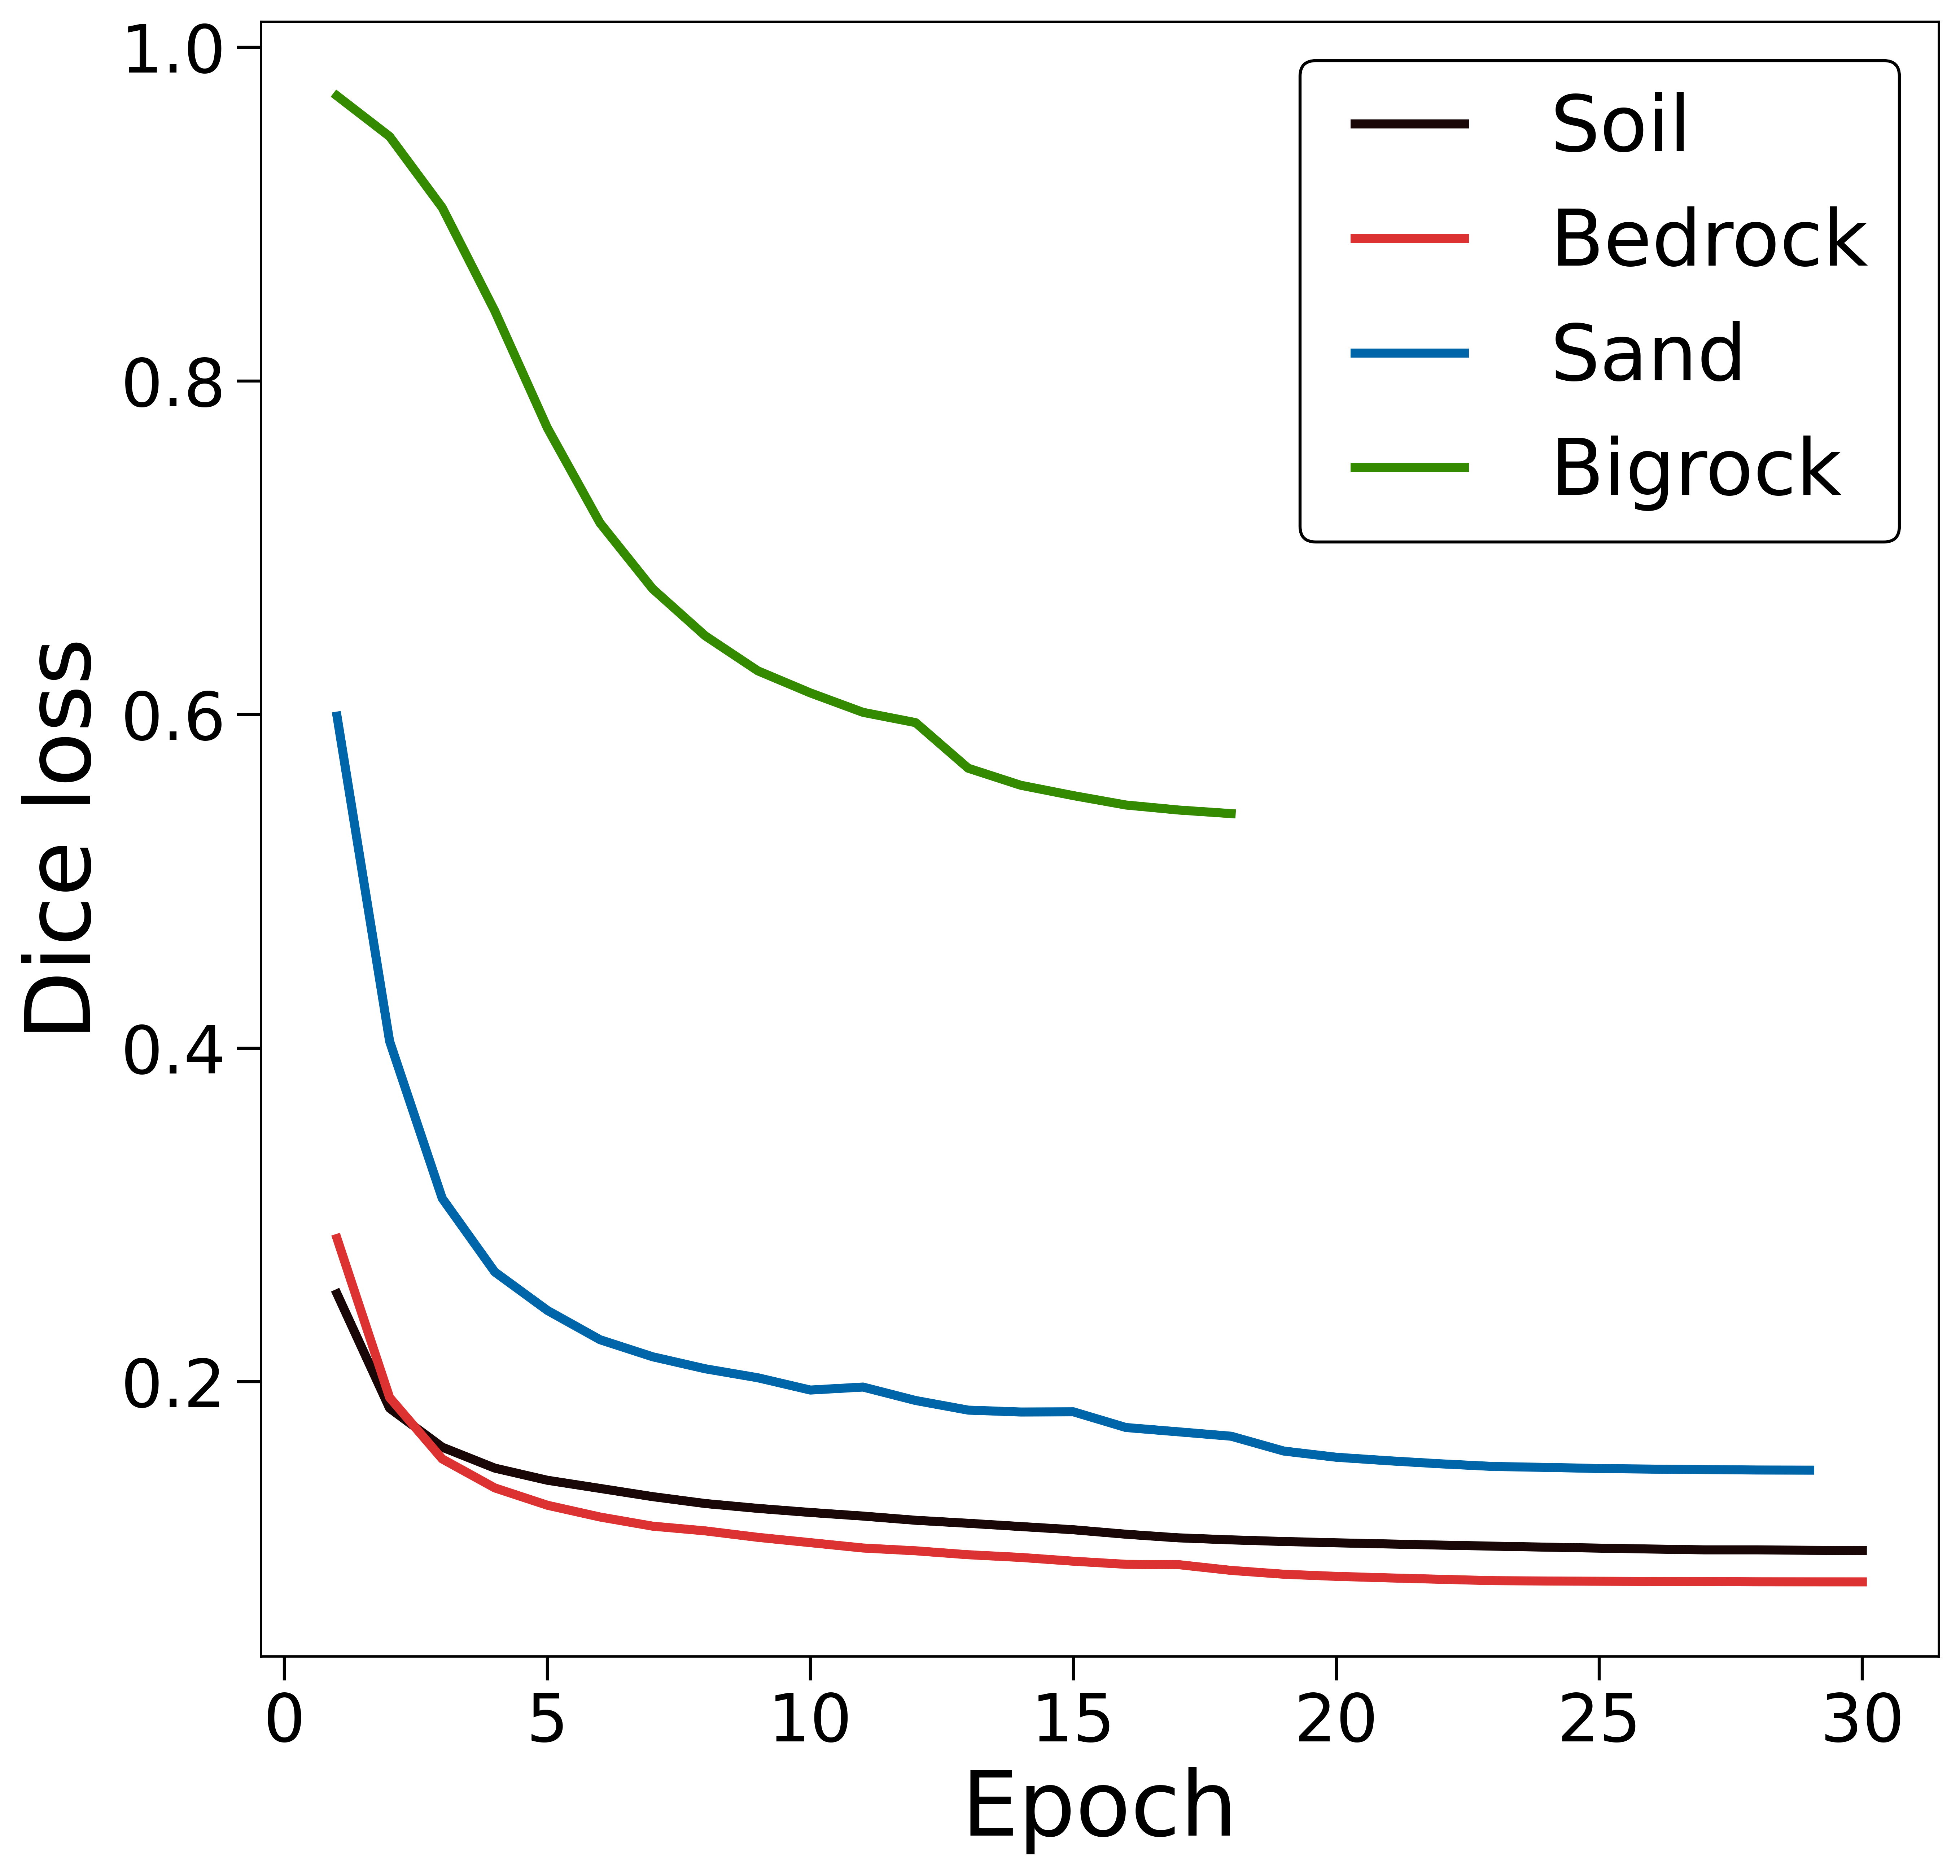

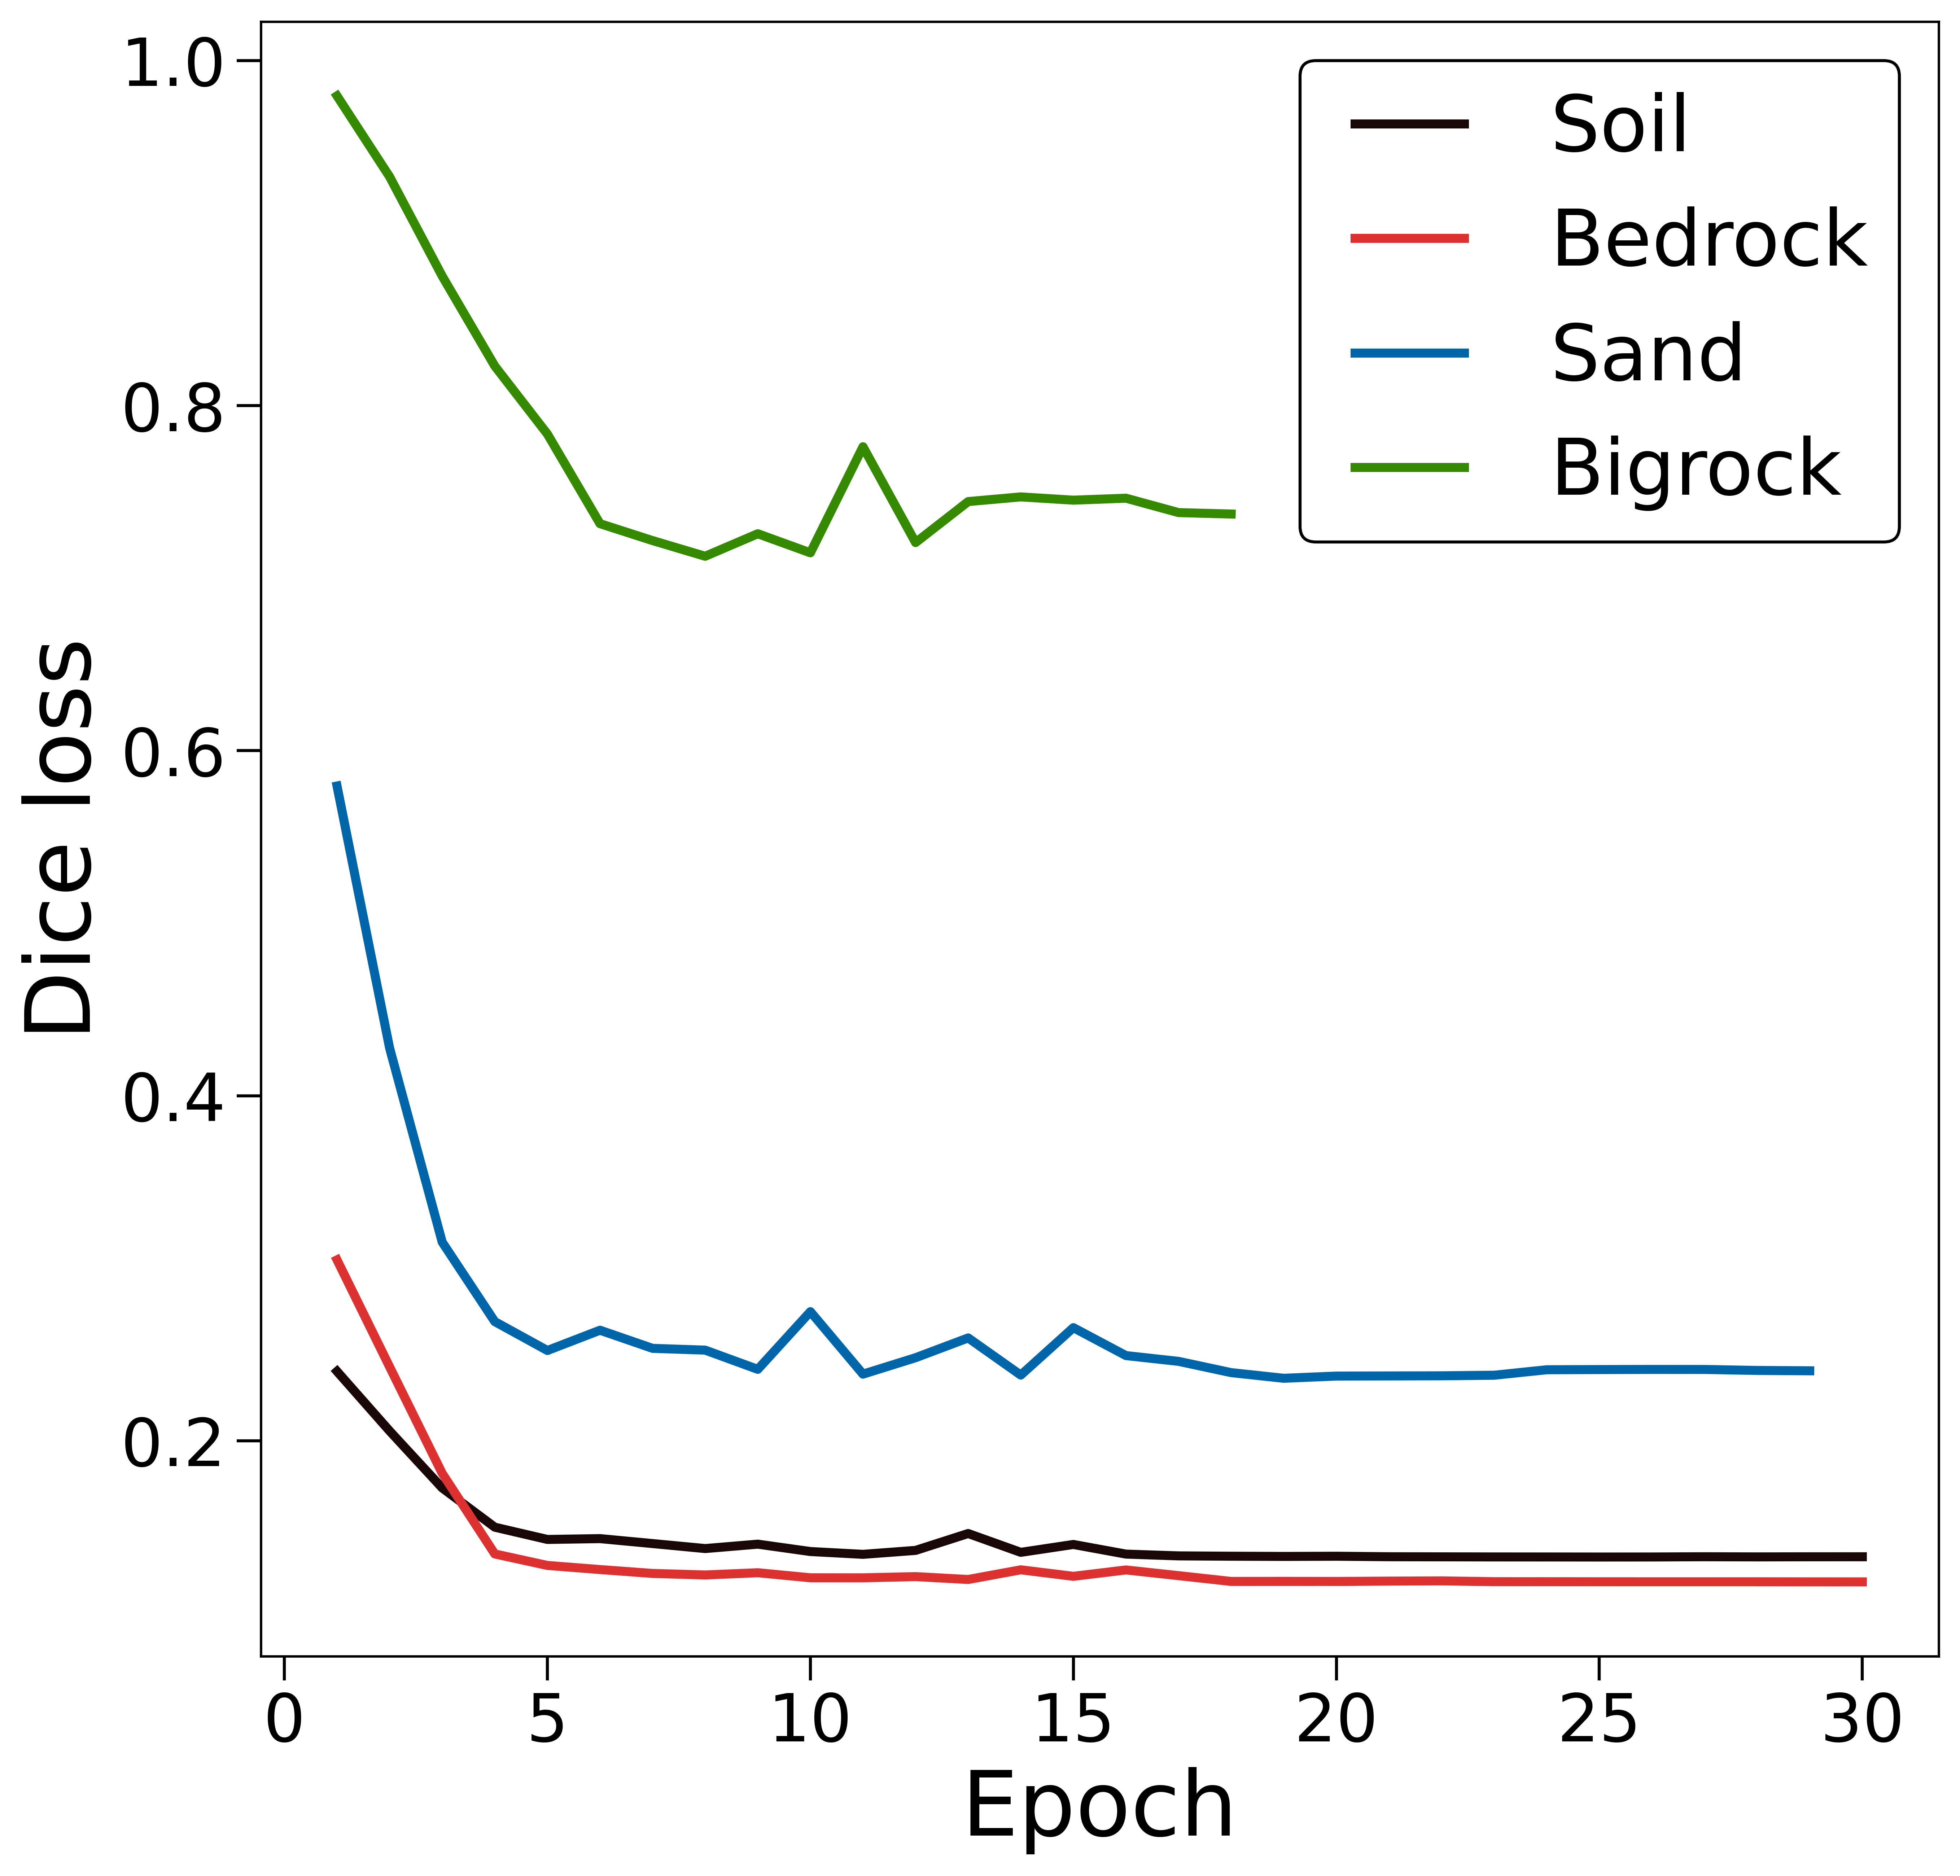

In [7]:
training_hist_soil = np.load('training_hist_soil.npy', allow_pickle = True)
training_hist_soil = training_hist_soil.tolist()
training_hist_bedrock = np.load('training_hist_bedrock.npy', allow_pickle = True)
training_hist_bedrock = training_hist_bedrock.tolist()
training_hist_sand = np.load('training_hist_sand.npy', allow_pickle = True)
training_hist_sand = training_hist_sand.tolist()
training_hist_bigrock = np.load('training_hist_bigrock.npy', allow_pickle = True)
training_hist_bigrock = training_hist_bigrock.tolist()

epoch_soil = np.arange(len(training_hist_soil['loss']))+1
epoch_bedrock = np.arange(len(training_hist_bedrock['loss']))+1
epoch_sand = np.arange(len(training_hist_sand['loss']))+1
epoch_bigrock = np.arange(len(training_hist_bigrock['loss']))+1

plt.style.use('paper_1column.mplstyle')
plt.figure()
plt.plot(epoch_soil,training_hist_soil['loss'],epoch_bedrock,training_hist_bedrock['loss'],epoch_sand,training_hist_sand['loss'],epoch_bigrock,training_hist_bigrock['loss'])
plt.legend(["Soil","Bedrock","Sand","Bigrock"])
plt.xlabel('Epoch')
plt.ylabel('Dice loss')
# plt.title('Training error vs. Epoch')
plt.figure()
plt.plot(epoch_soil,training_hist_soil['val_loss'],epoch_bedrock,training_hist_bedrock['val_loss'],epoch_sand,training_hist_sand['val_loss'],epoch_bigrock,training_hist_bigrock['val_loss'])
plt.legend(["Soil","Bedrock","Sand","Bigrock"])
plt.xlabel('Epoch')
plt.ylabel('Dice loss')
# plt.title('Validation error vs. Epoch')

1/1 [==============================] - 1s 963ms/step
0.51959586
1/1 [==============================] - 0s 91ms/step
0.52458847
1/1 [==============================] - 0s 96ms/step
0.7649771
1/1 [==============================] - 0s 89ms/step
0.91668385
1/1 [==============================] - 0s 89ms/step
0.76542264
1/1 [==============================] - 0s 87ms/step
0.7404503
1/1 [==============================] - 0s 83ms/step
0.7490076
1/1 [==============================] - 0s 85ms/step
0.5338931
1/1 [==============================] - 0s 75ms/step
0.6075051
1/1 [==============================] - 0s 83ms/step
0.9026563
1/1 [==============================] - 0s 78ms/step
0.8919575
1/1 [==============================] - 0s 76ms/step
0.87110454
1/1 [==============================] - 0s 84ms/step
0.94088376
1/1 [==============================] - 0s 75ms/step
0.82866645
1/1 [==============================] - 0s 87ms/step
0.8734132
1/1 [==============================] - 0s 76ms/step
0.8433252


/var/folders/cw/6csl35793c15sxyc4r1hx4x40000gn/T/ipykernel_9793/3397241034.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(12, 12))


0.49804923
1/1 [==============================] - 0s 82ms/step
0.8925518
1/1 [==============================] - 0s 80ms/step
0.6548152
1/1 [==============================] - 0s 80ms/step
0.86637414


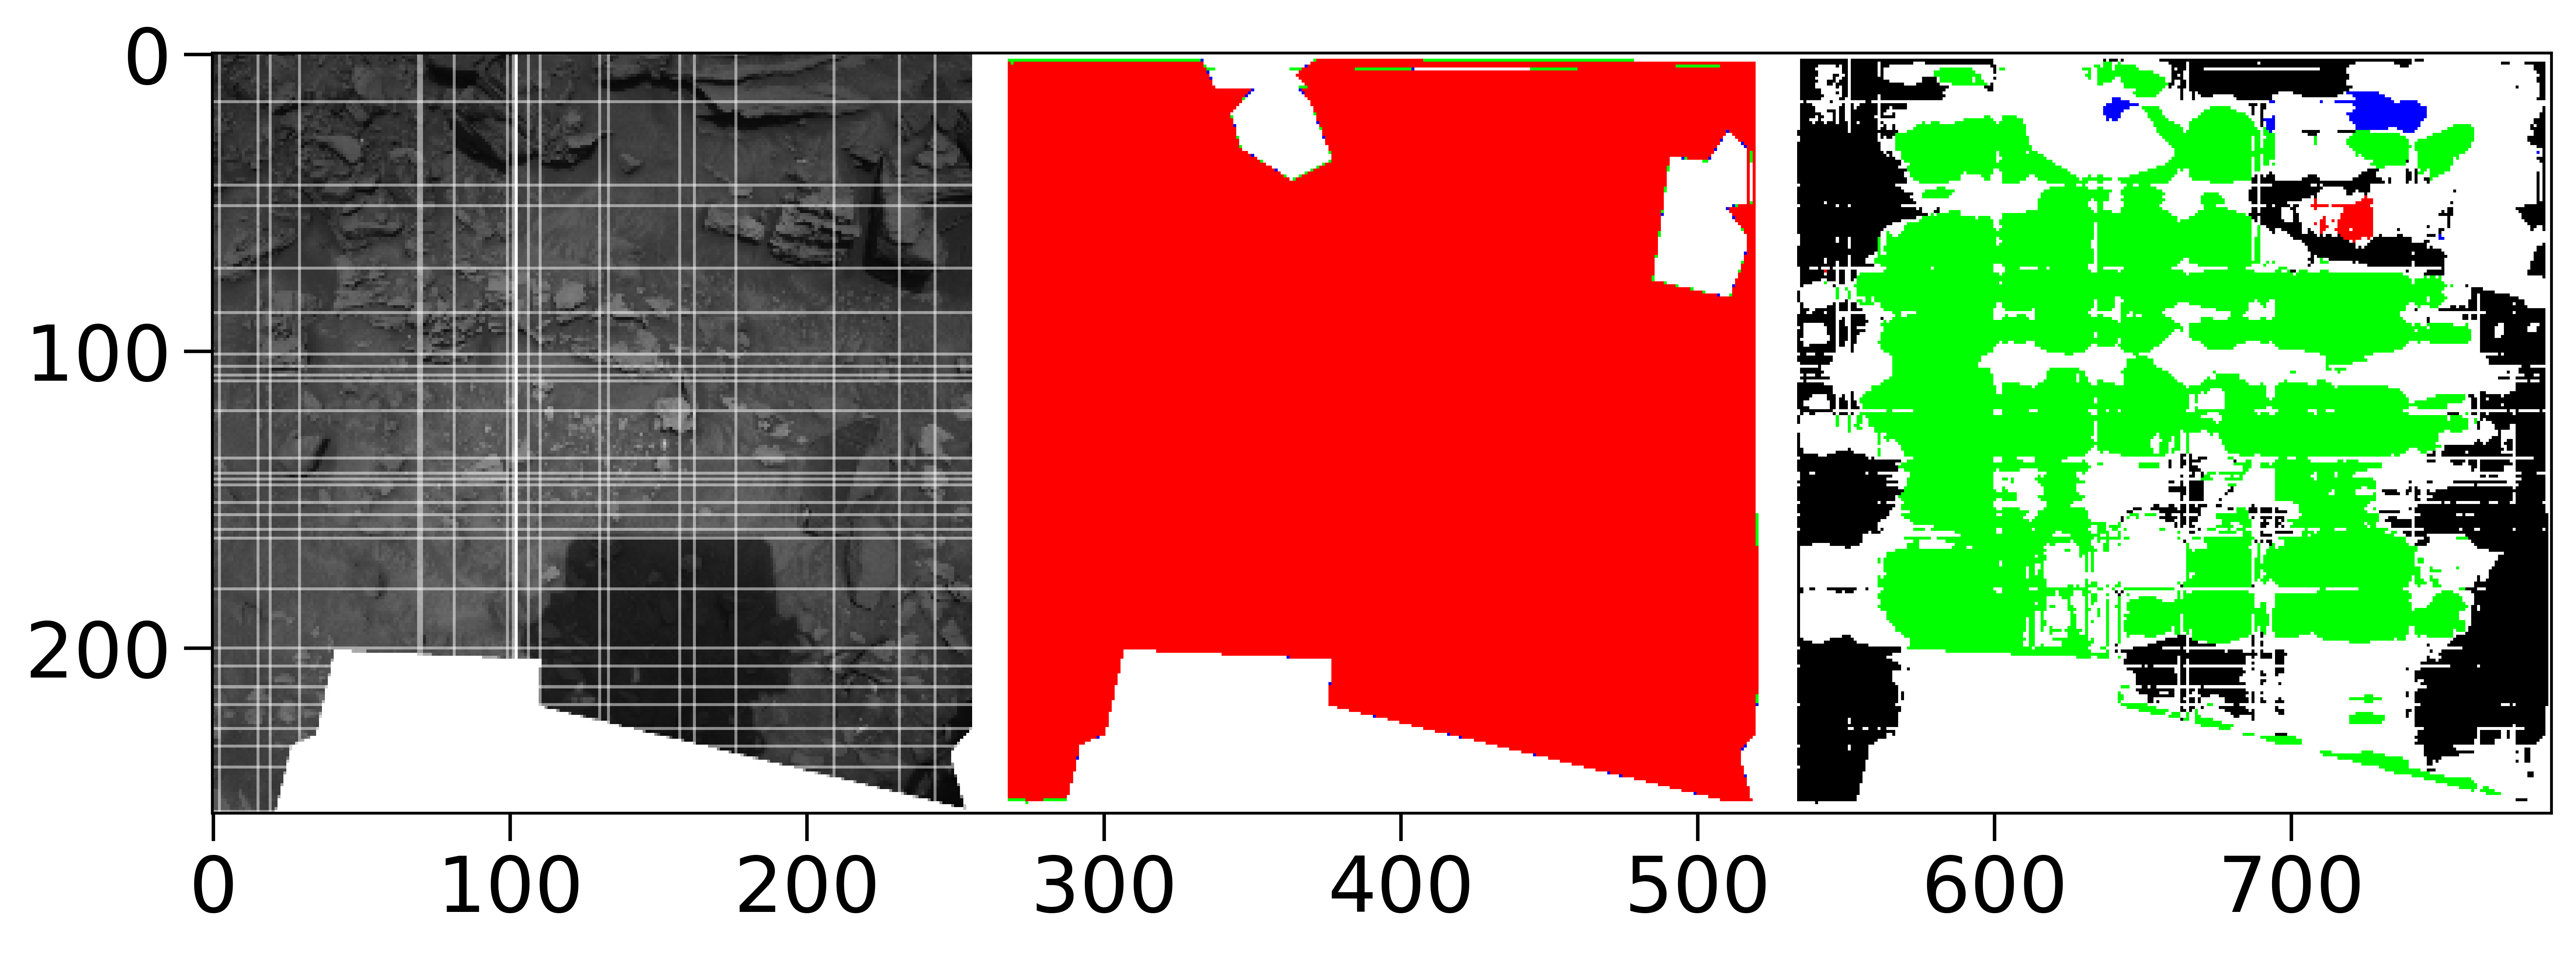

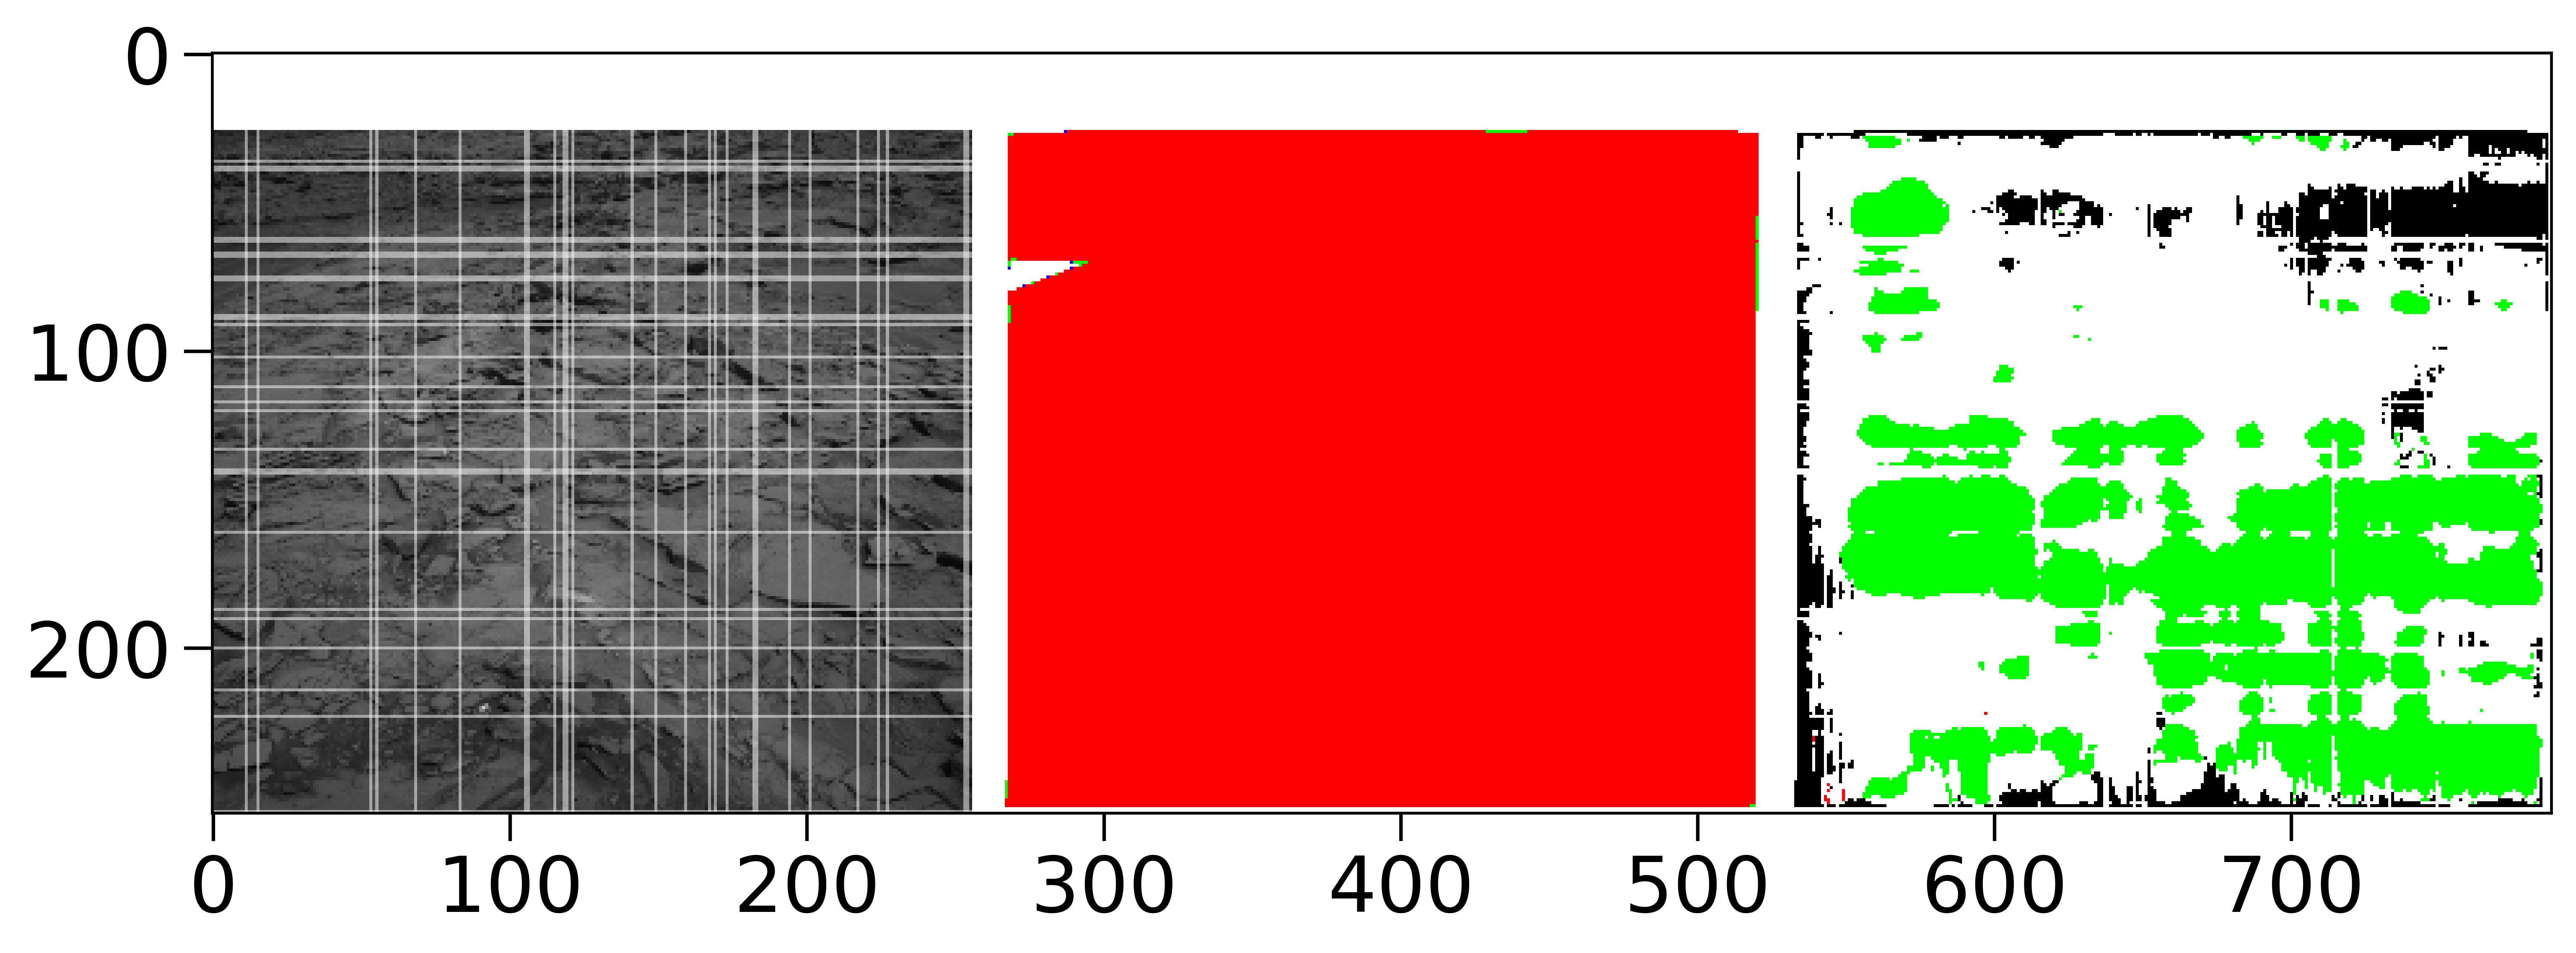

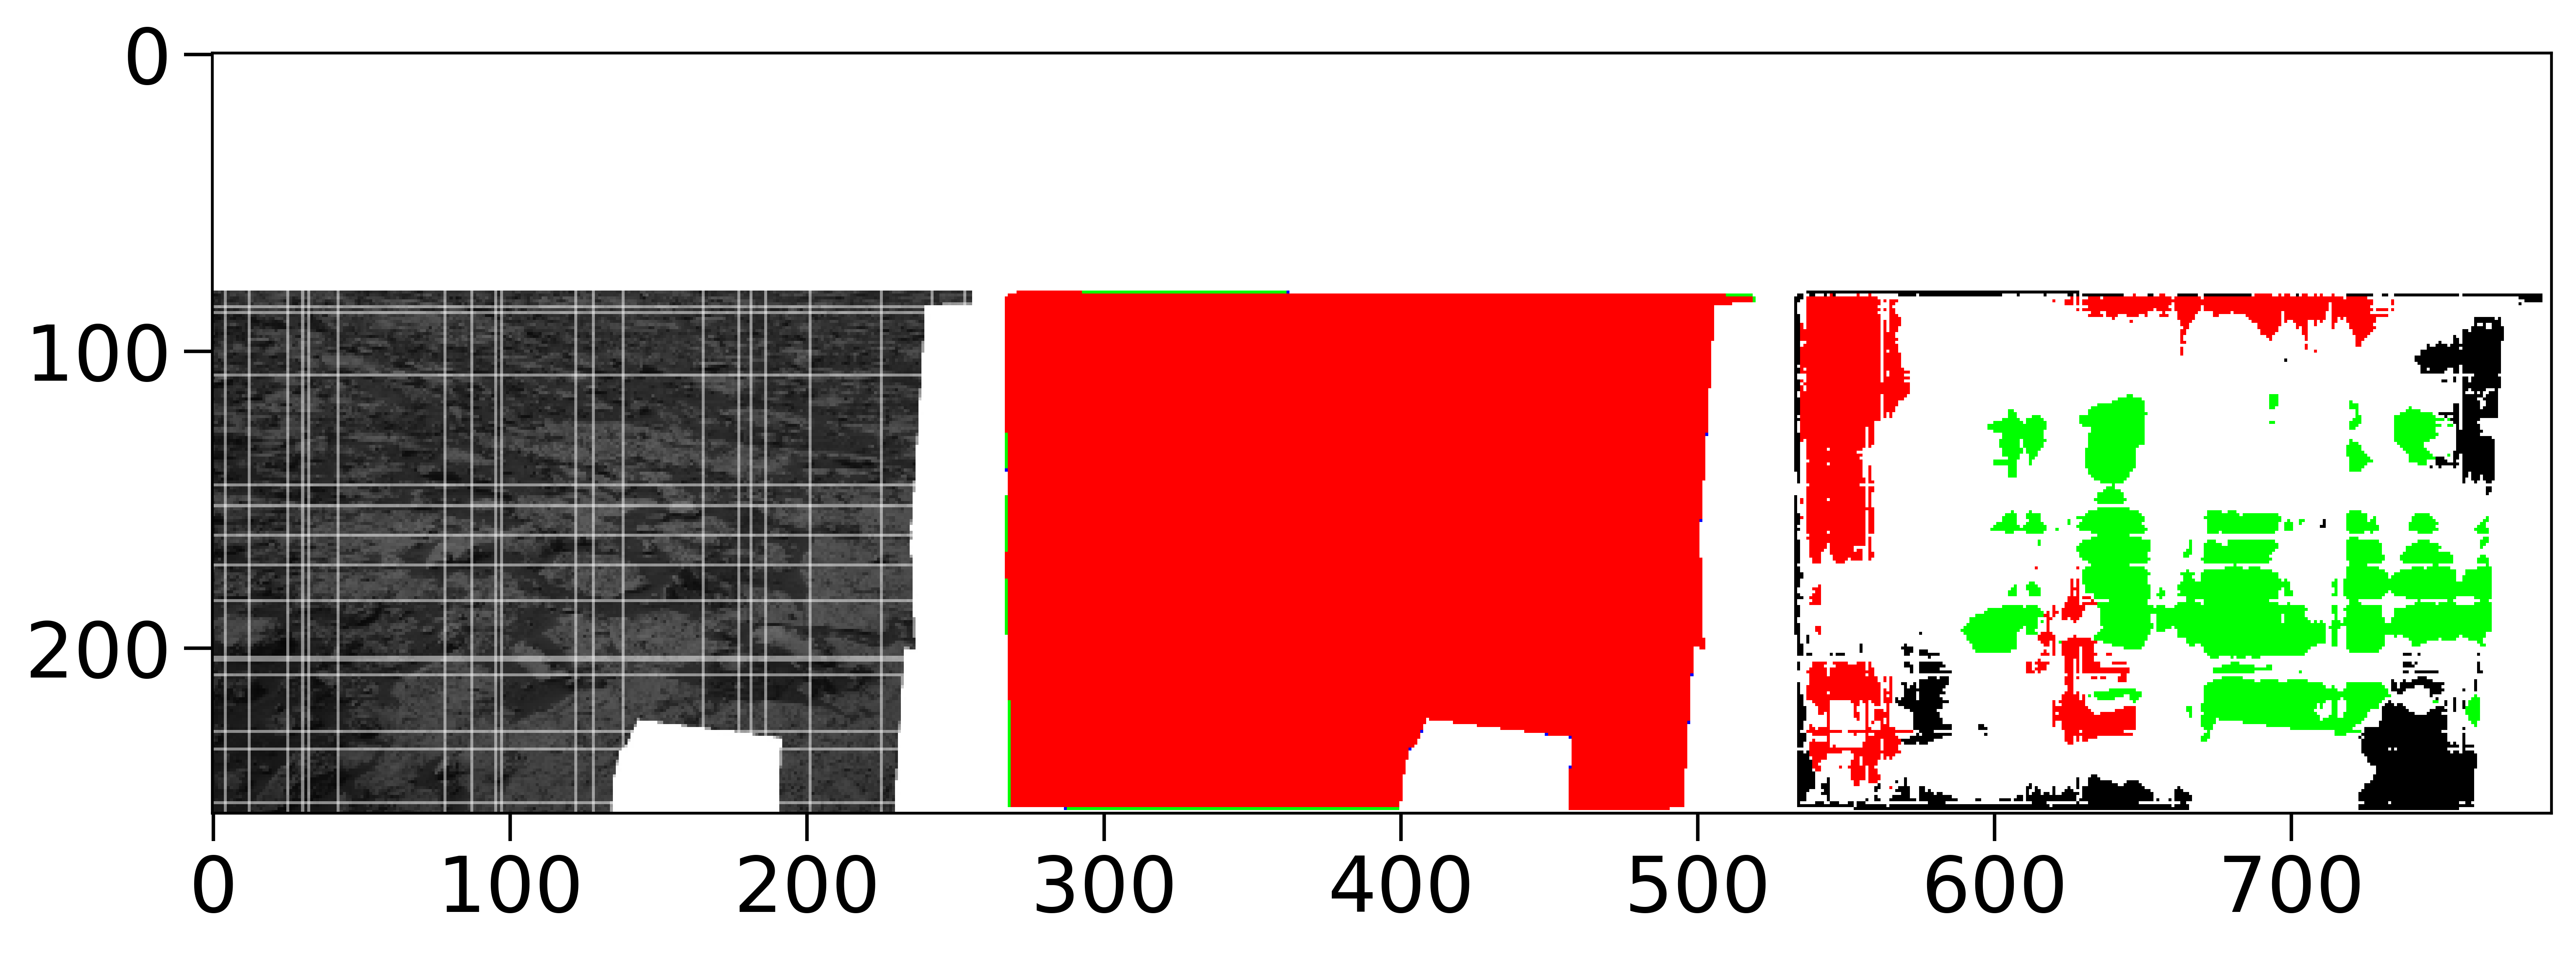

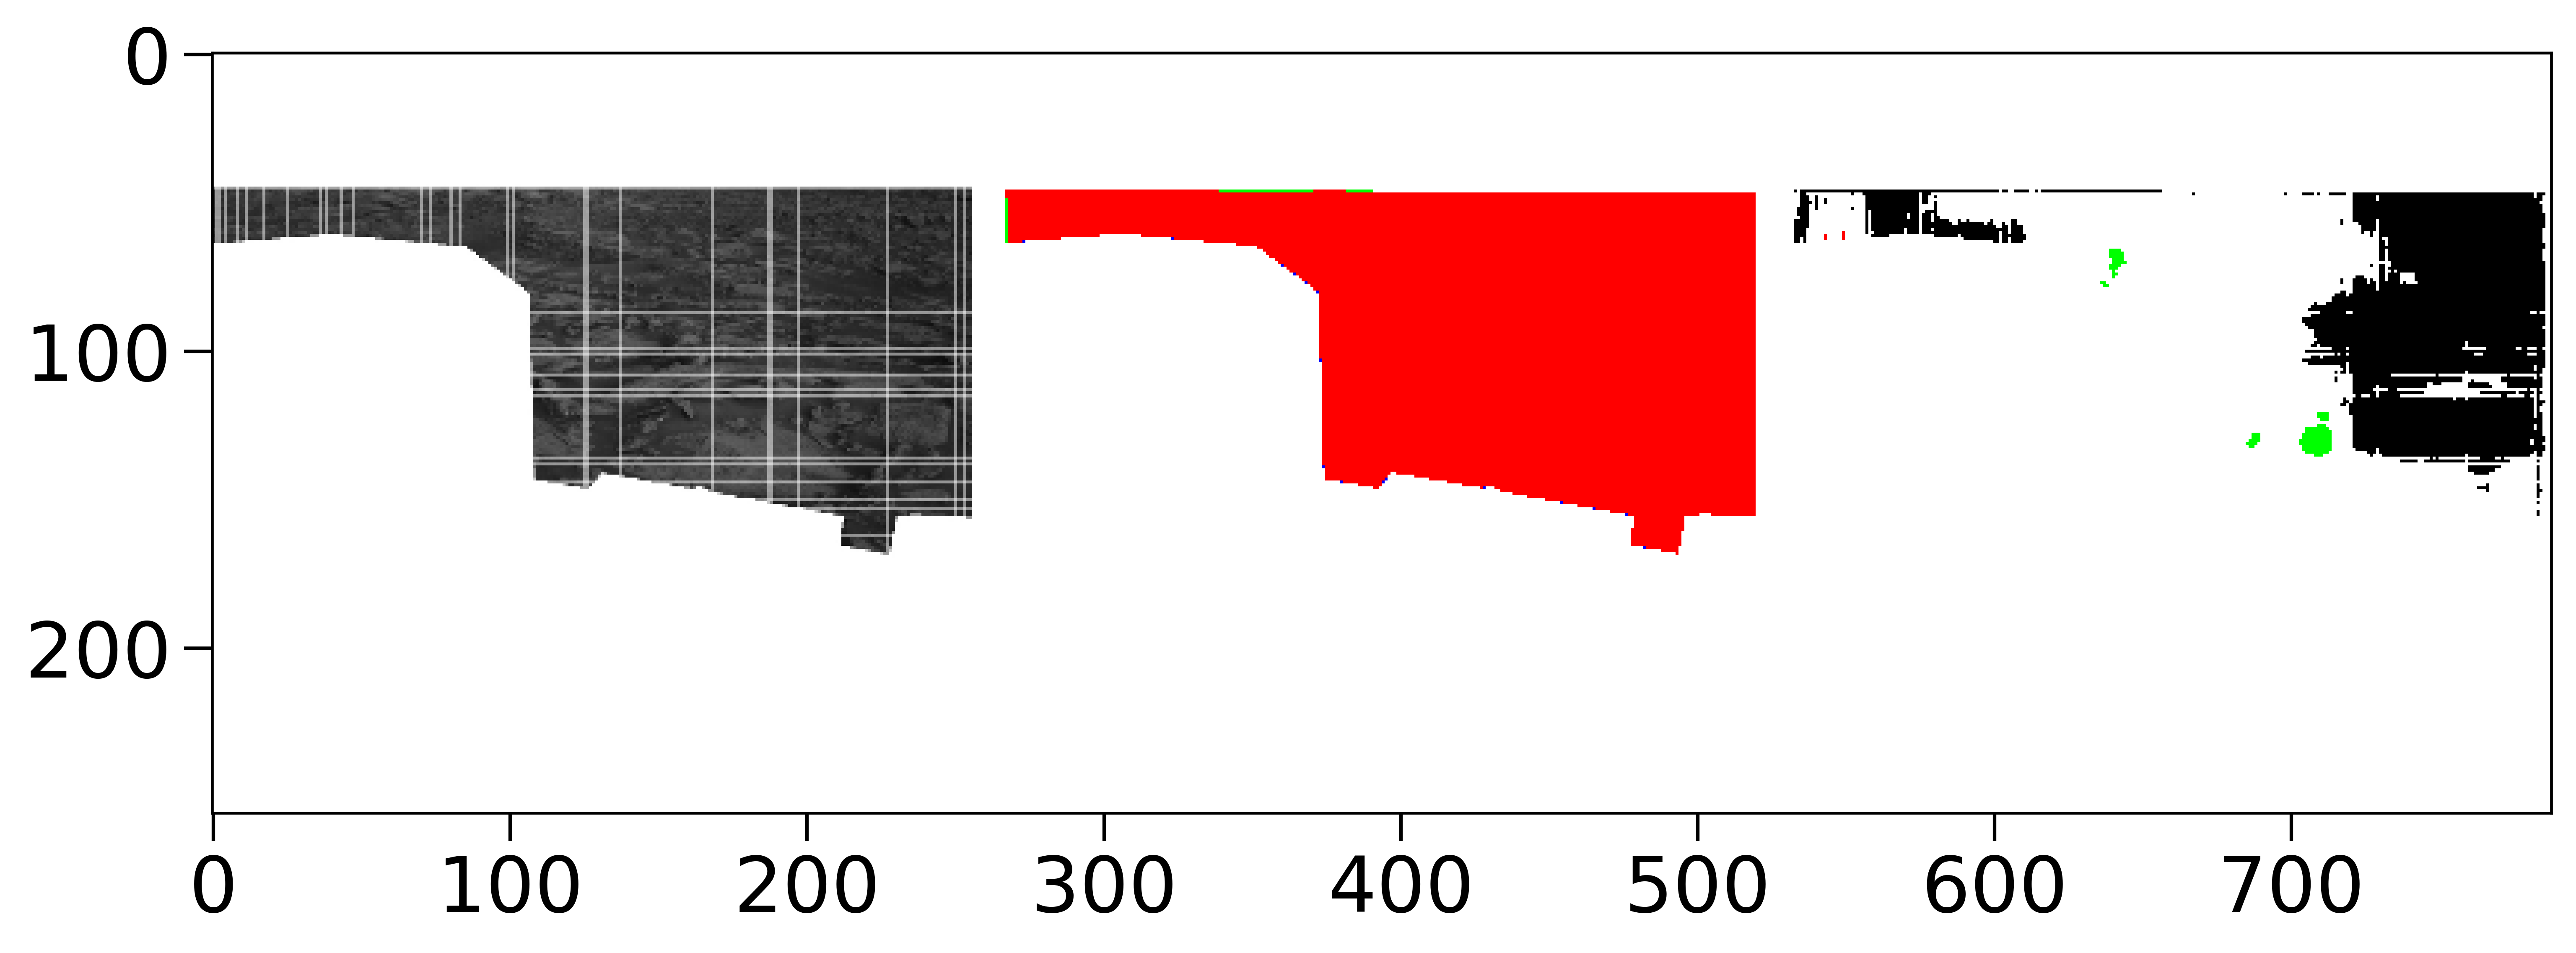

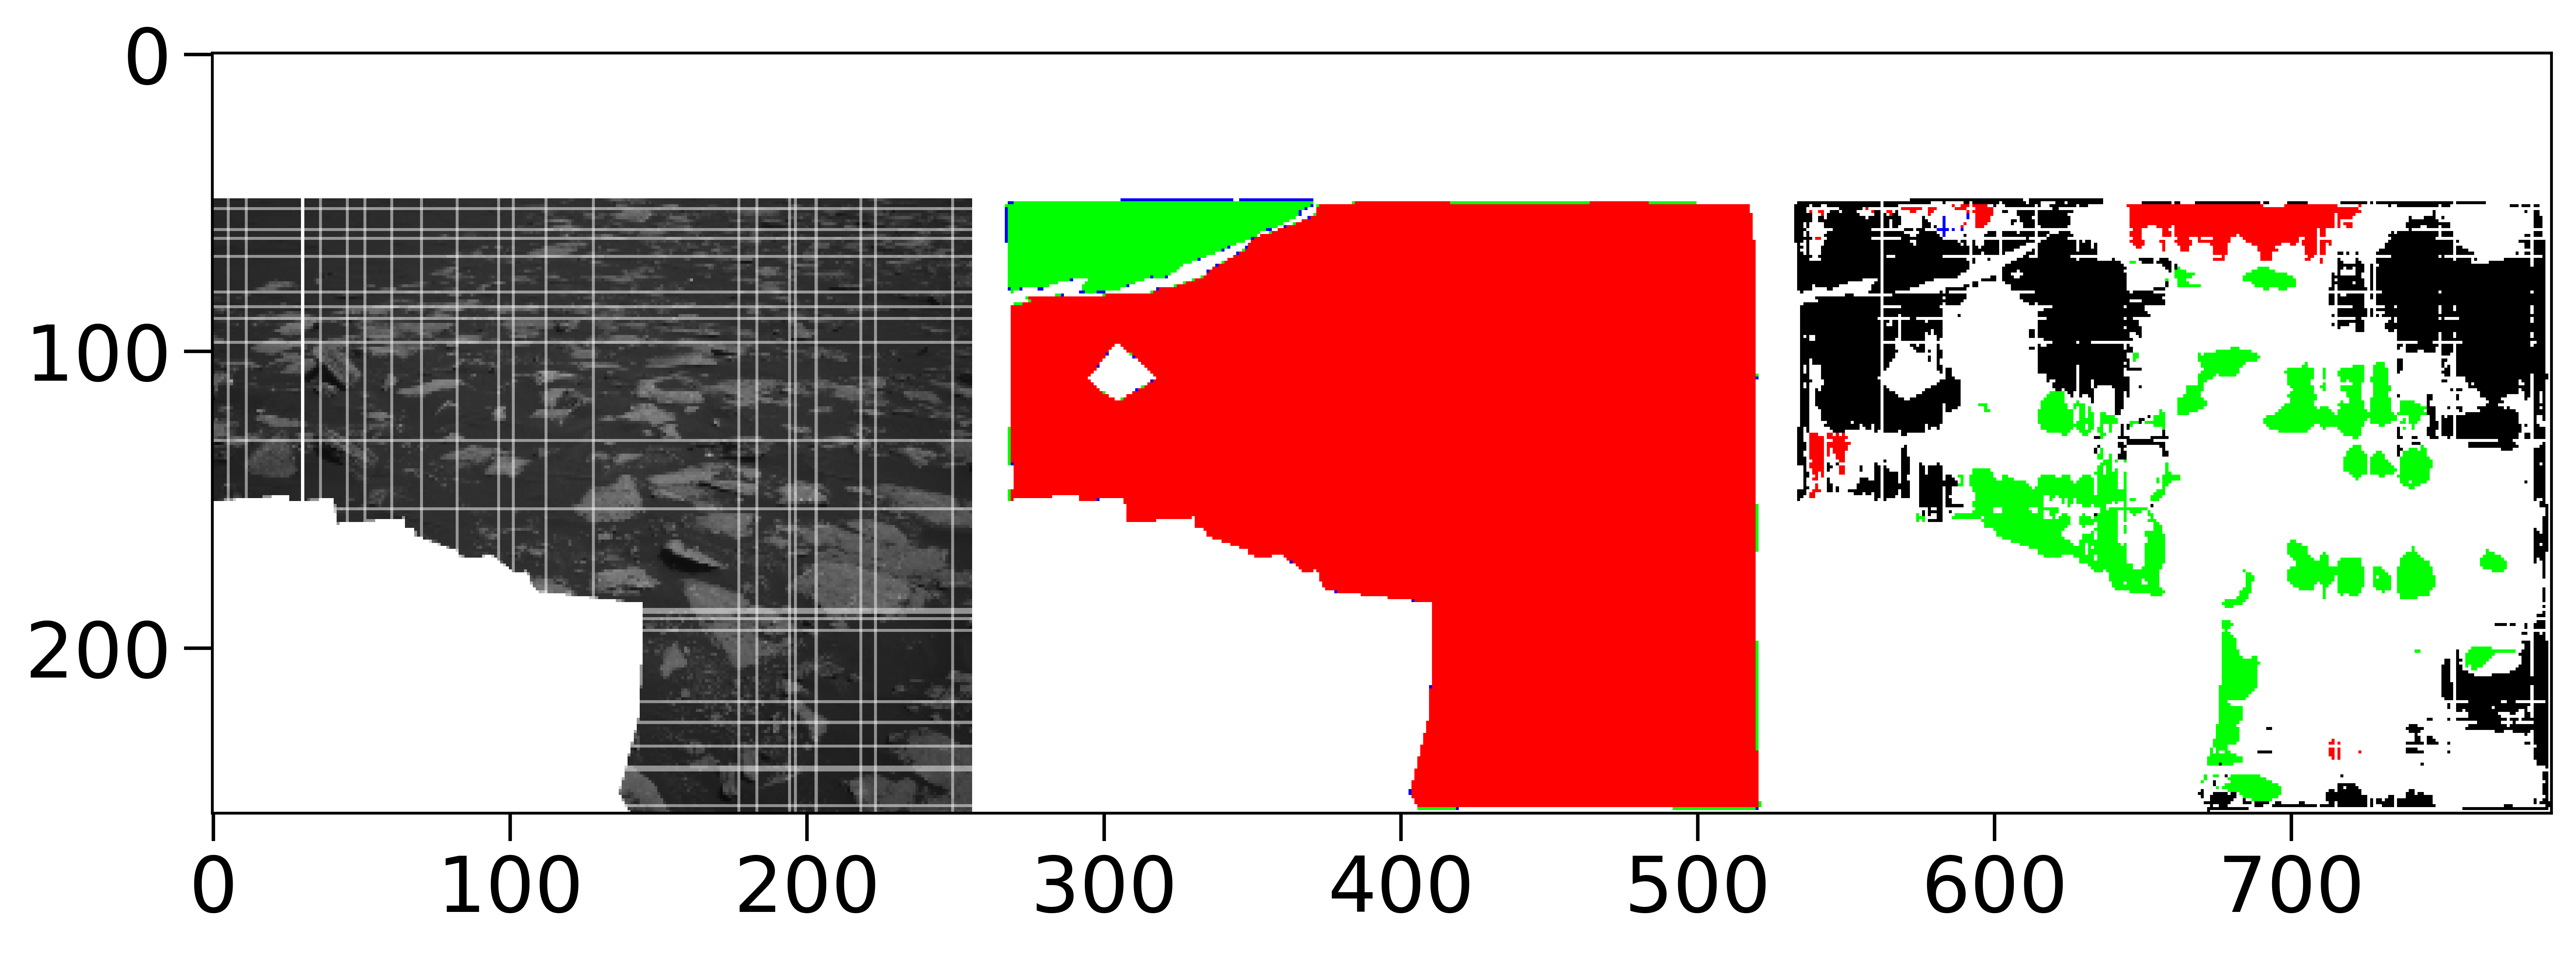

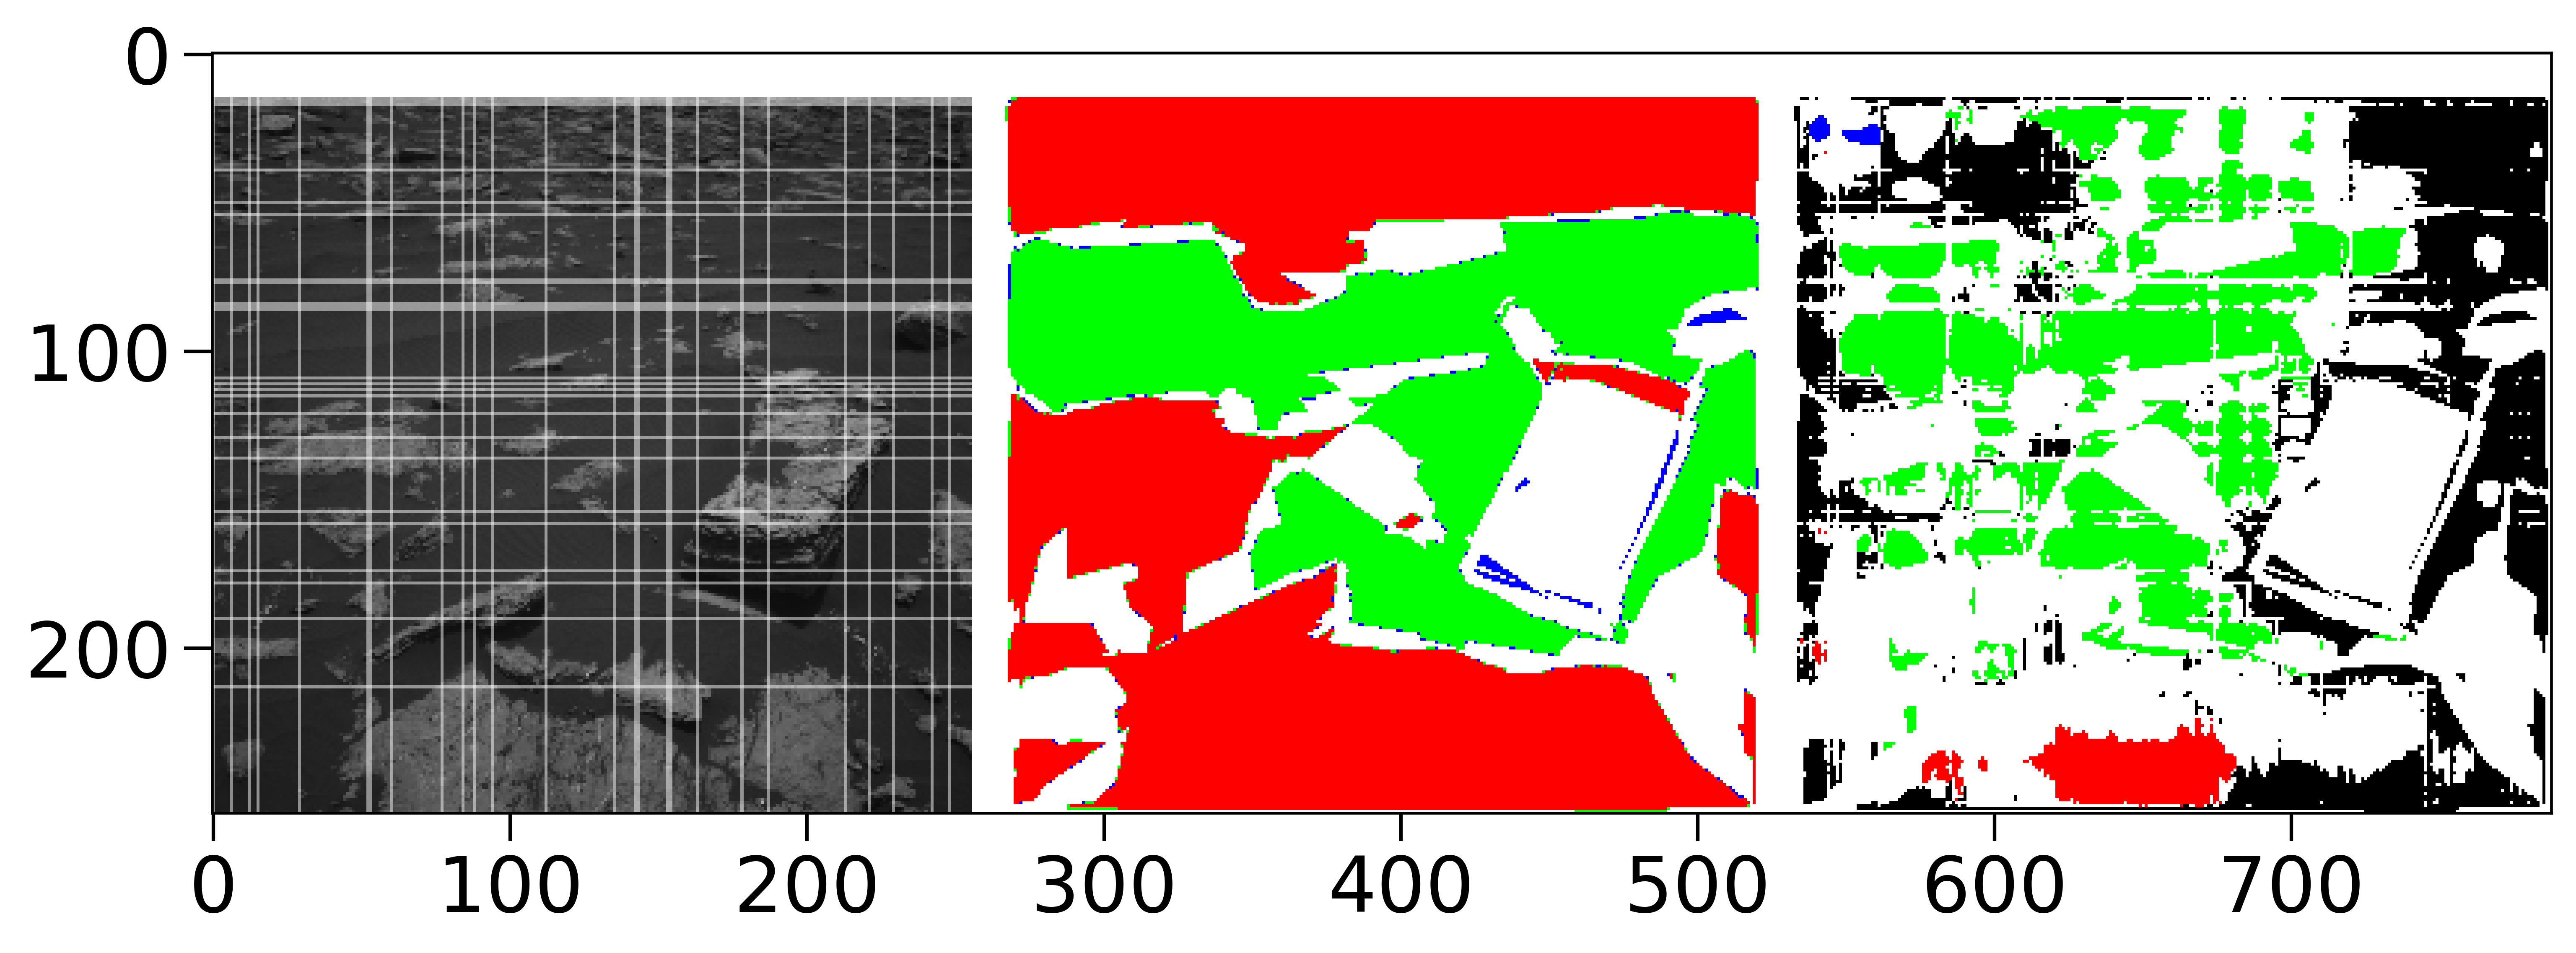

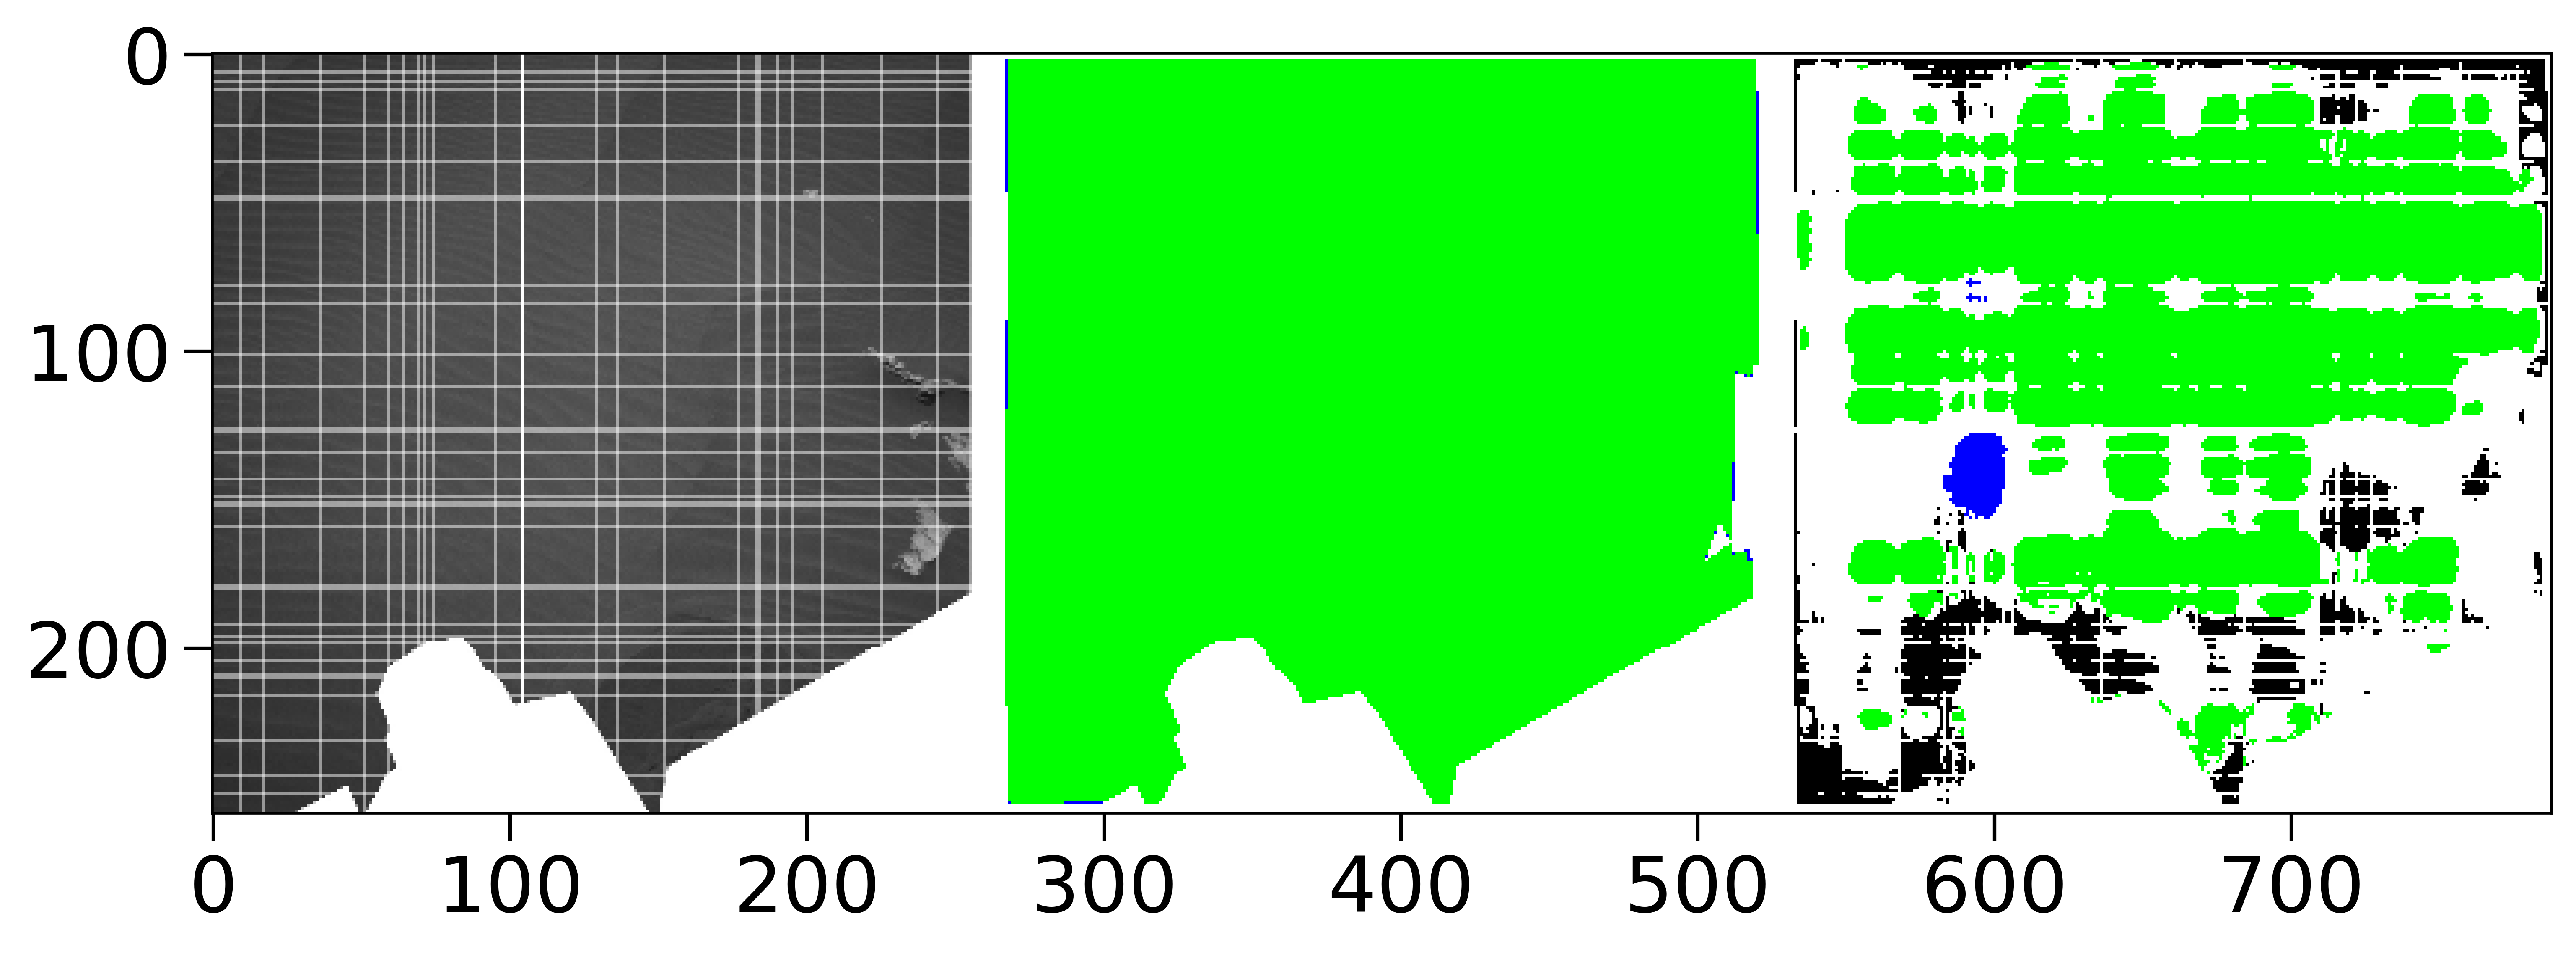

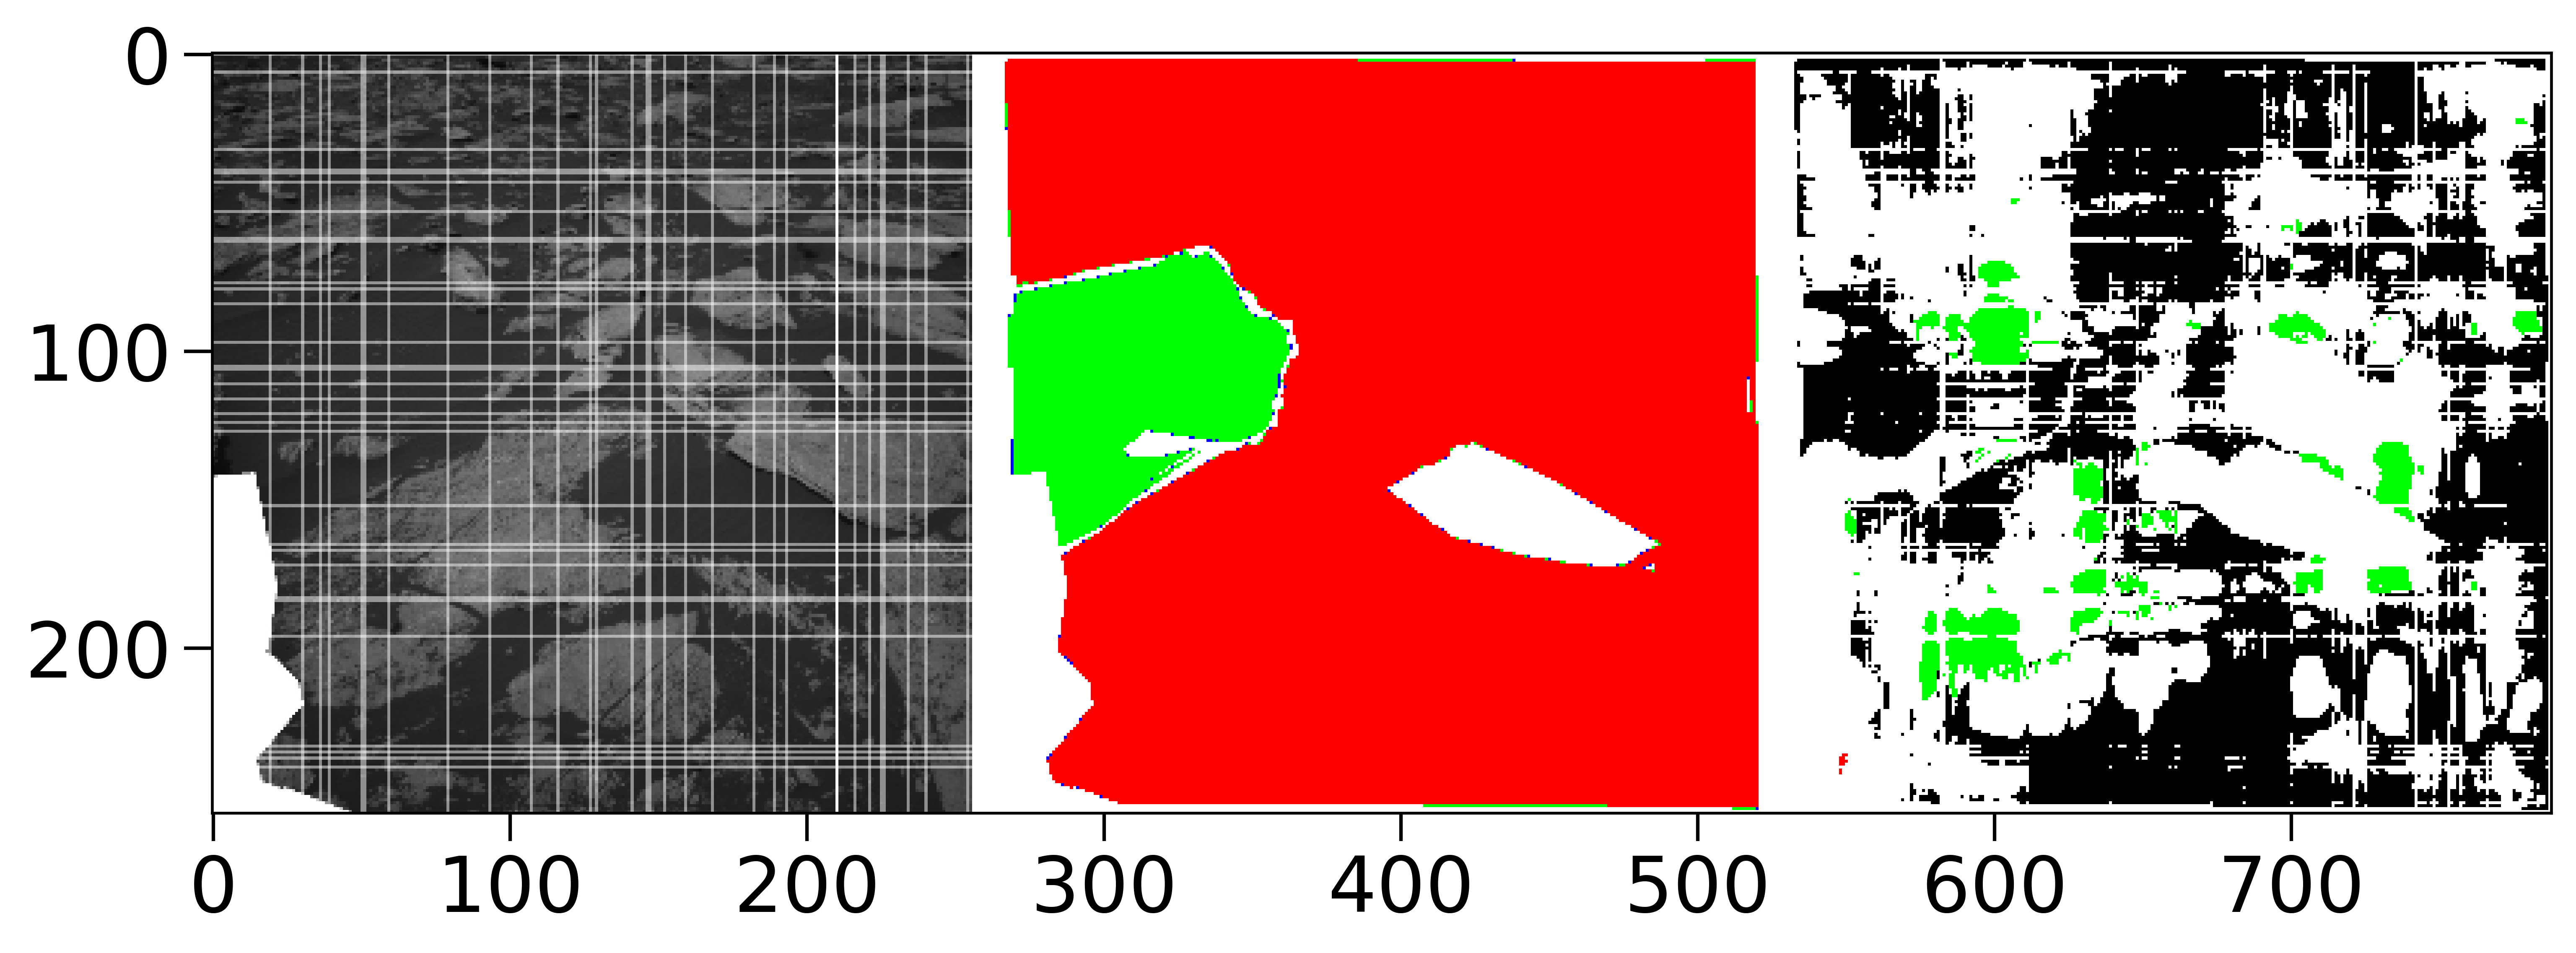

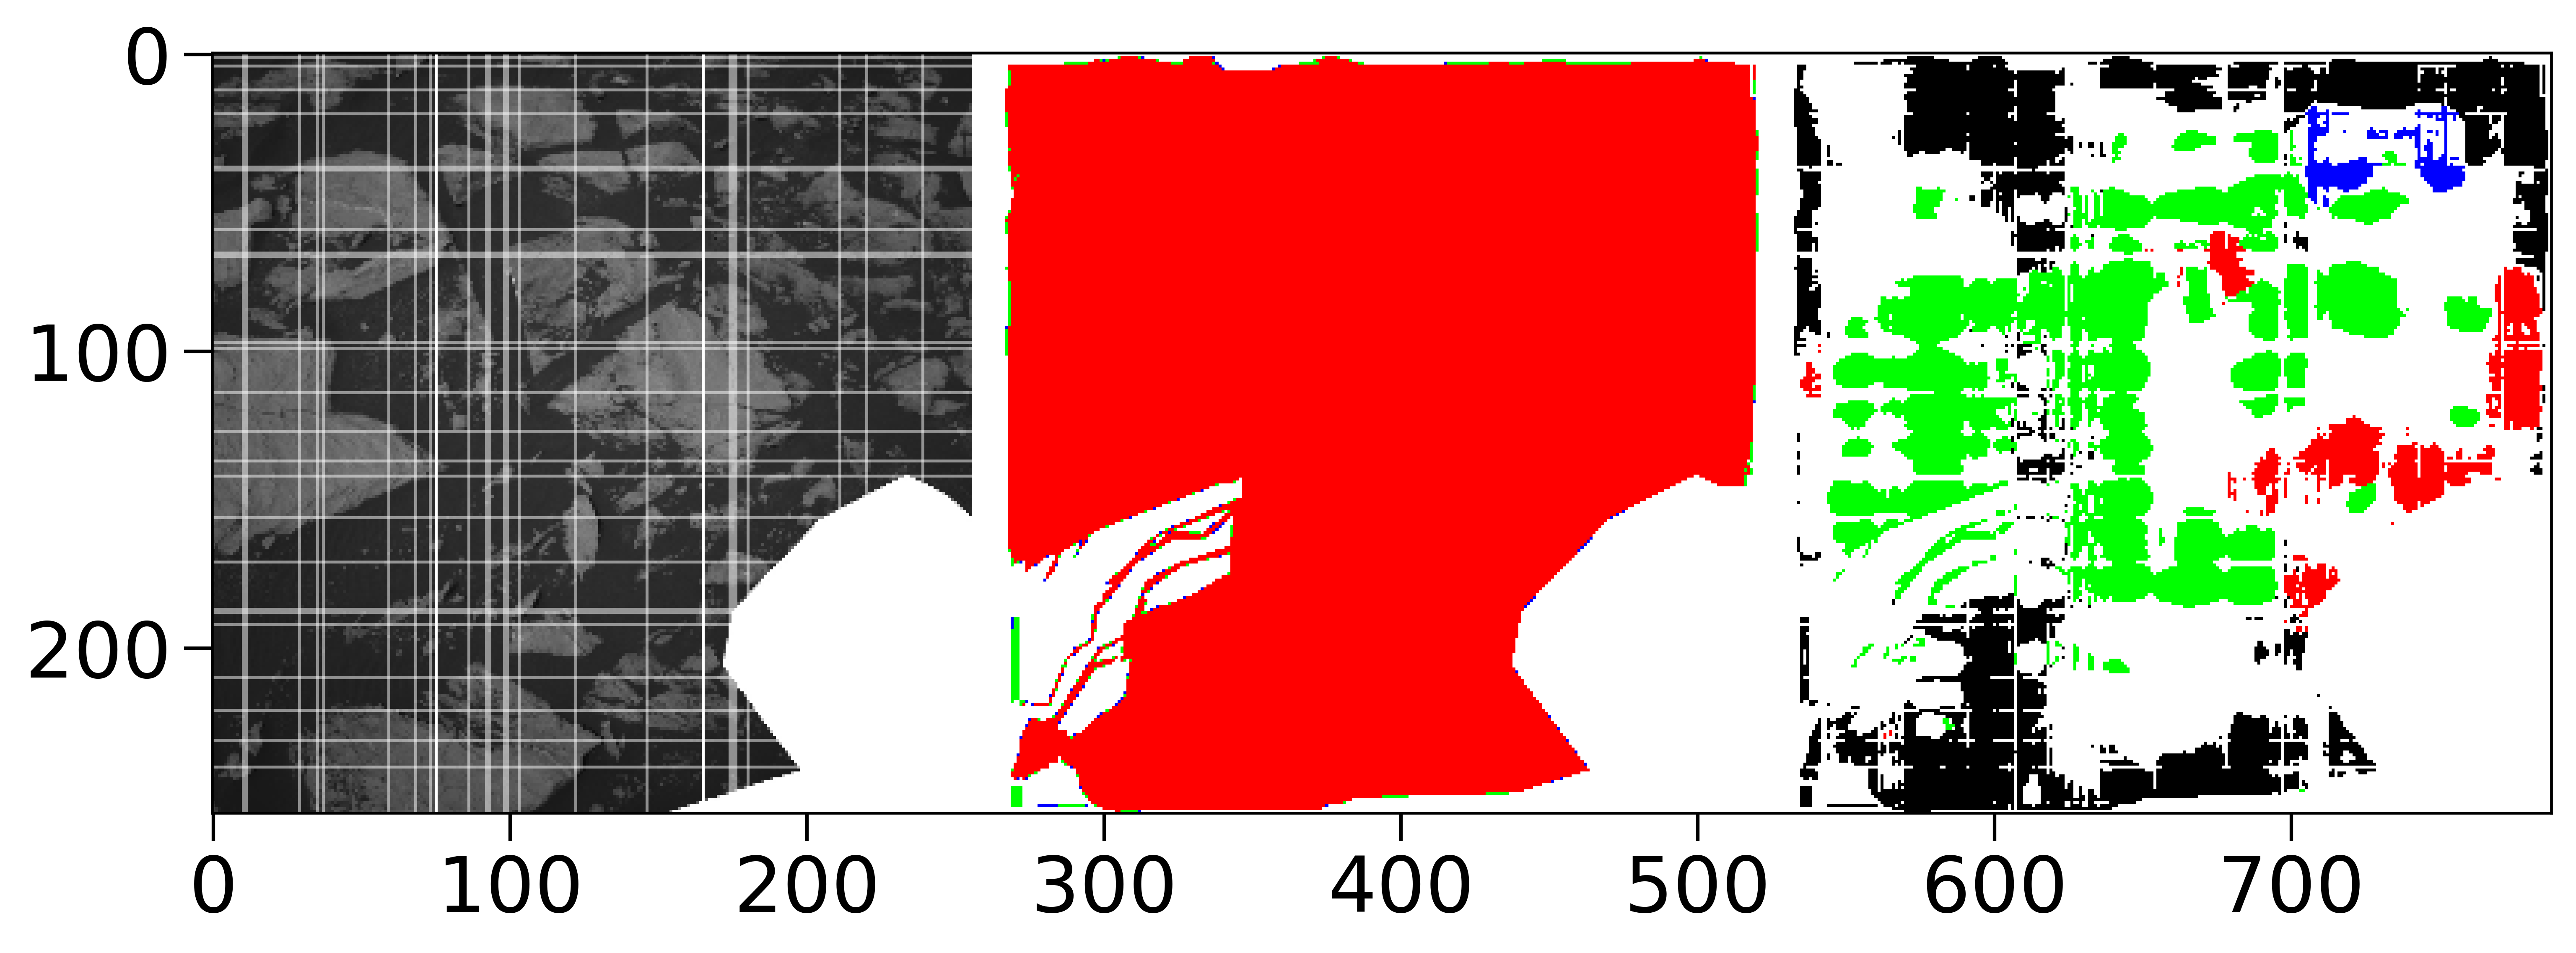

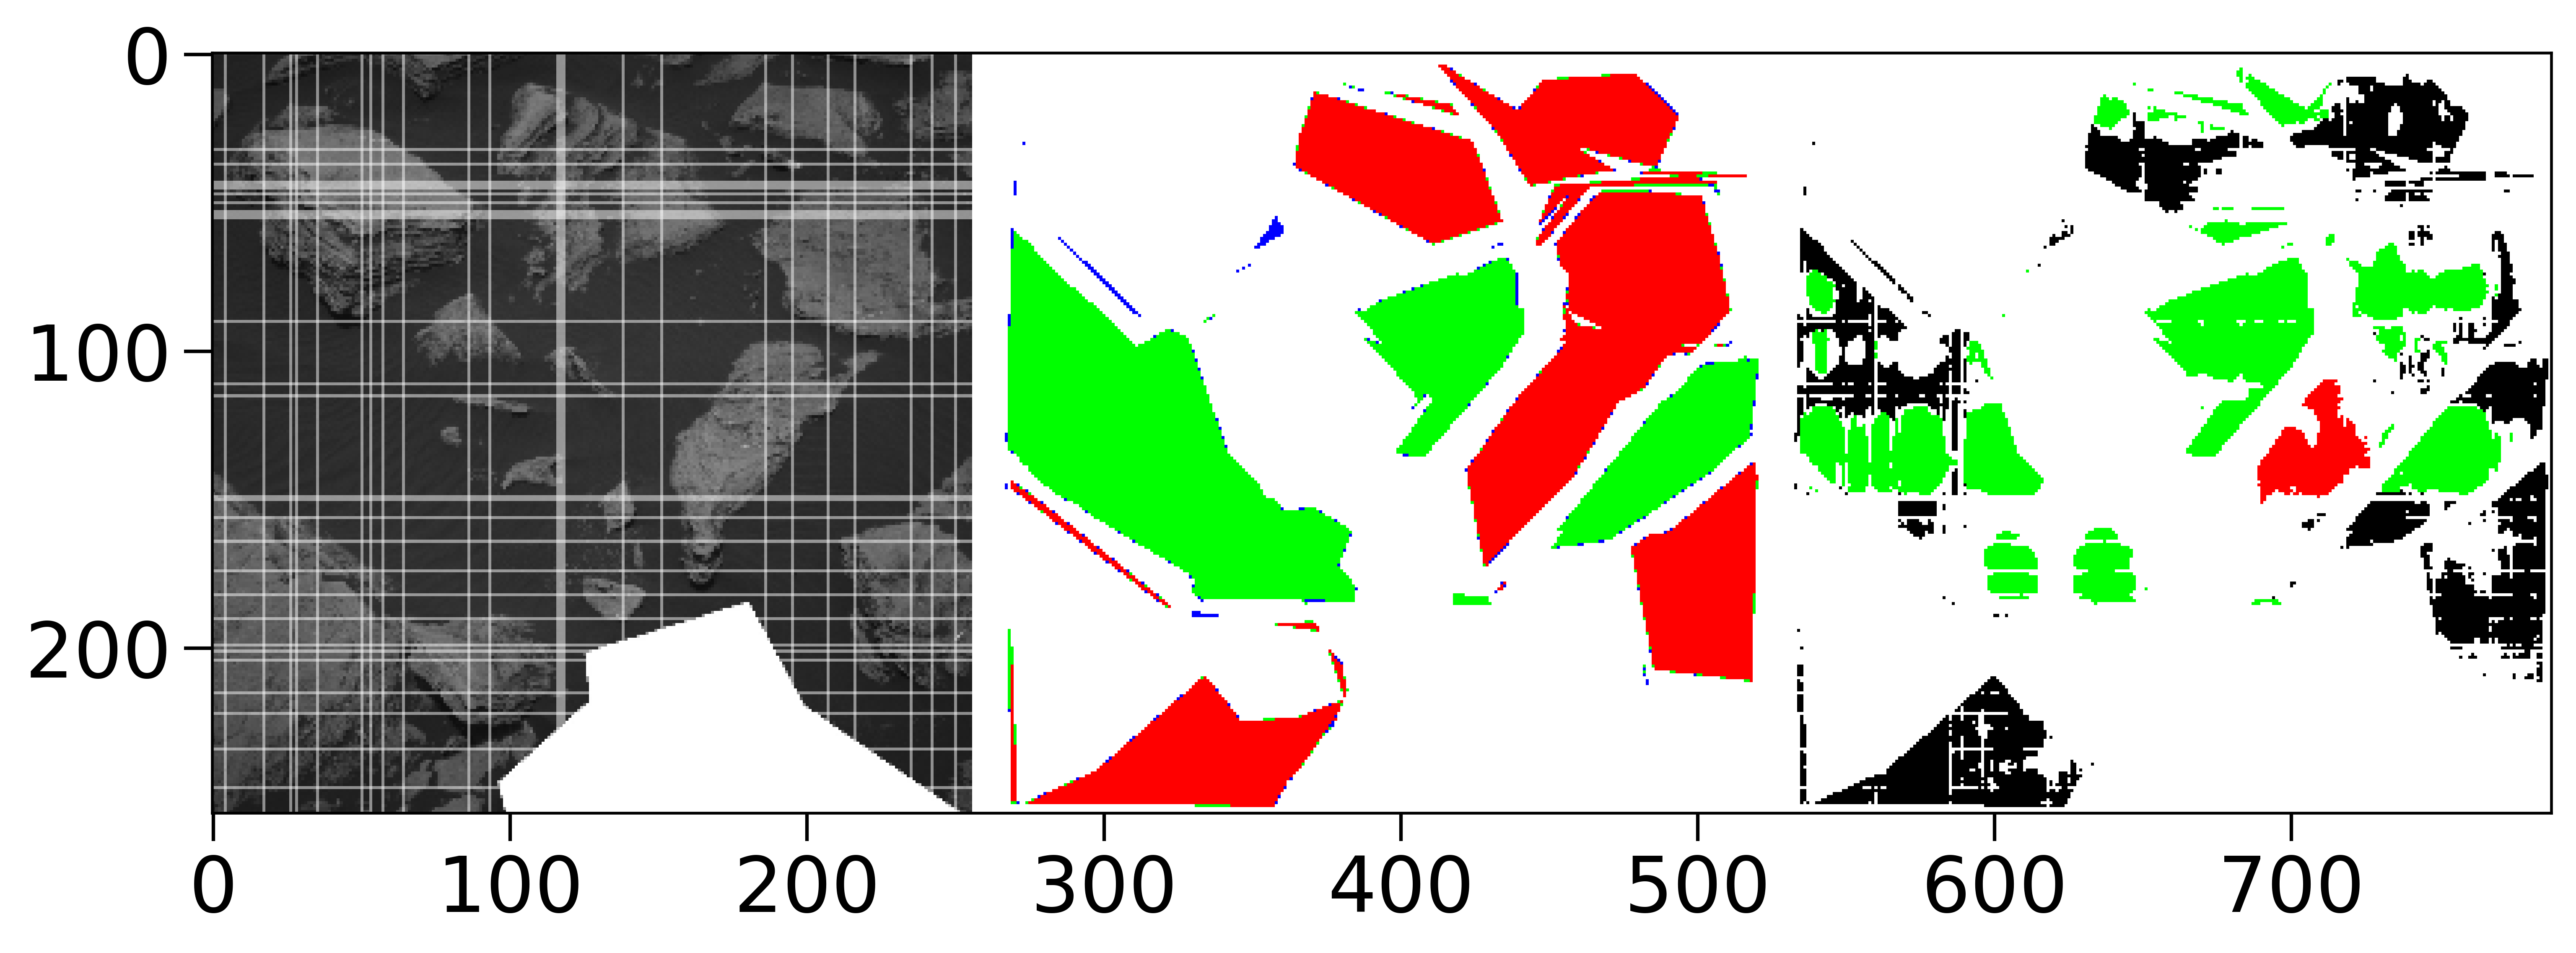

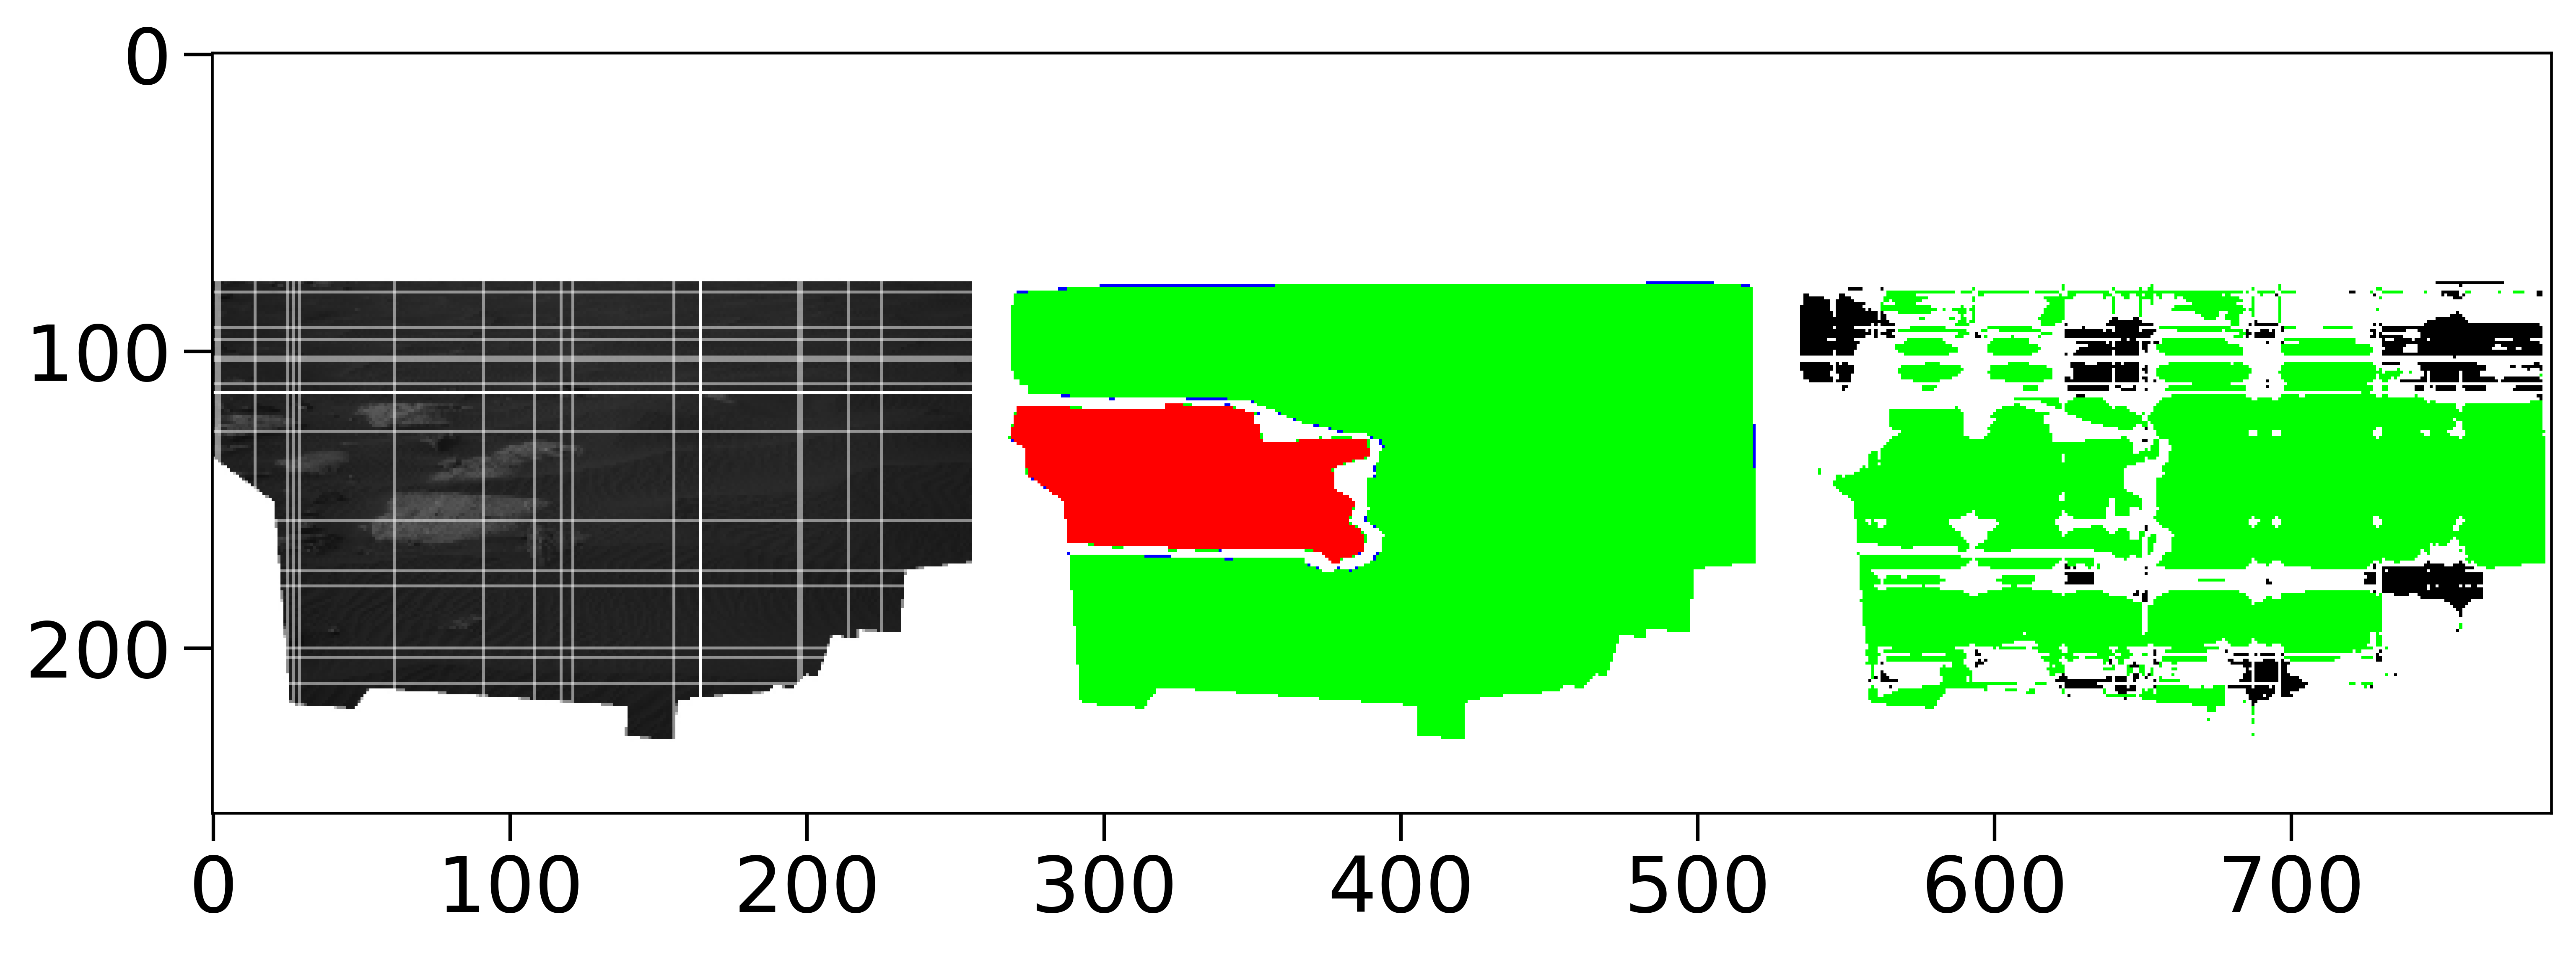

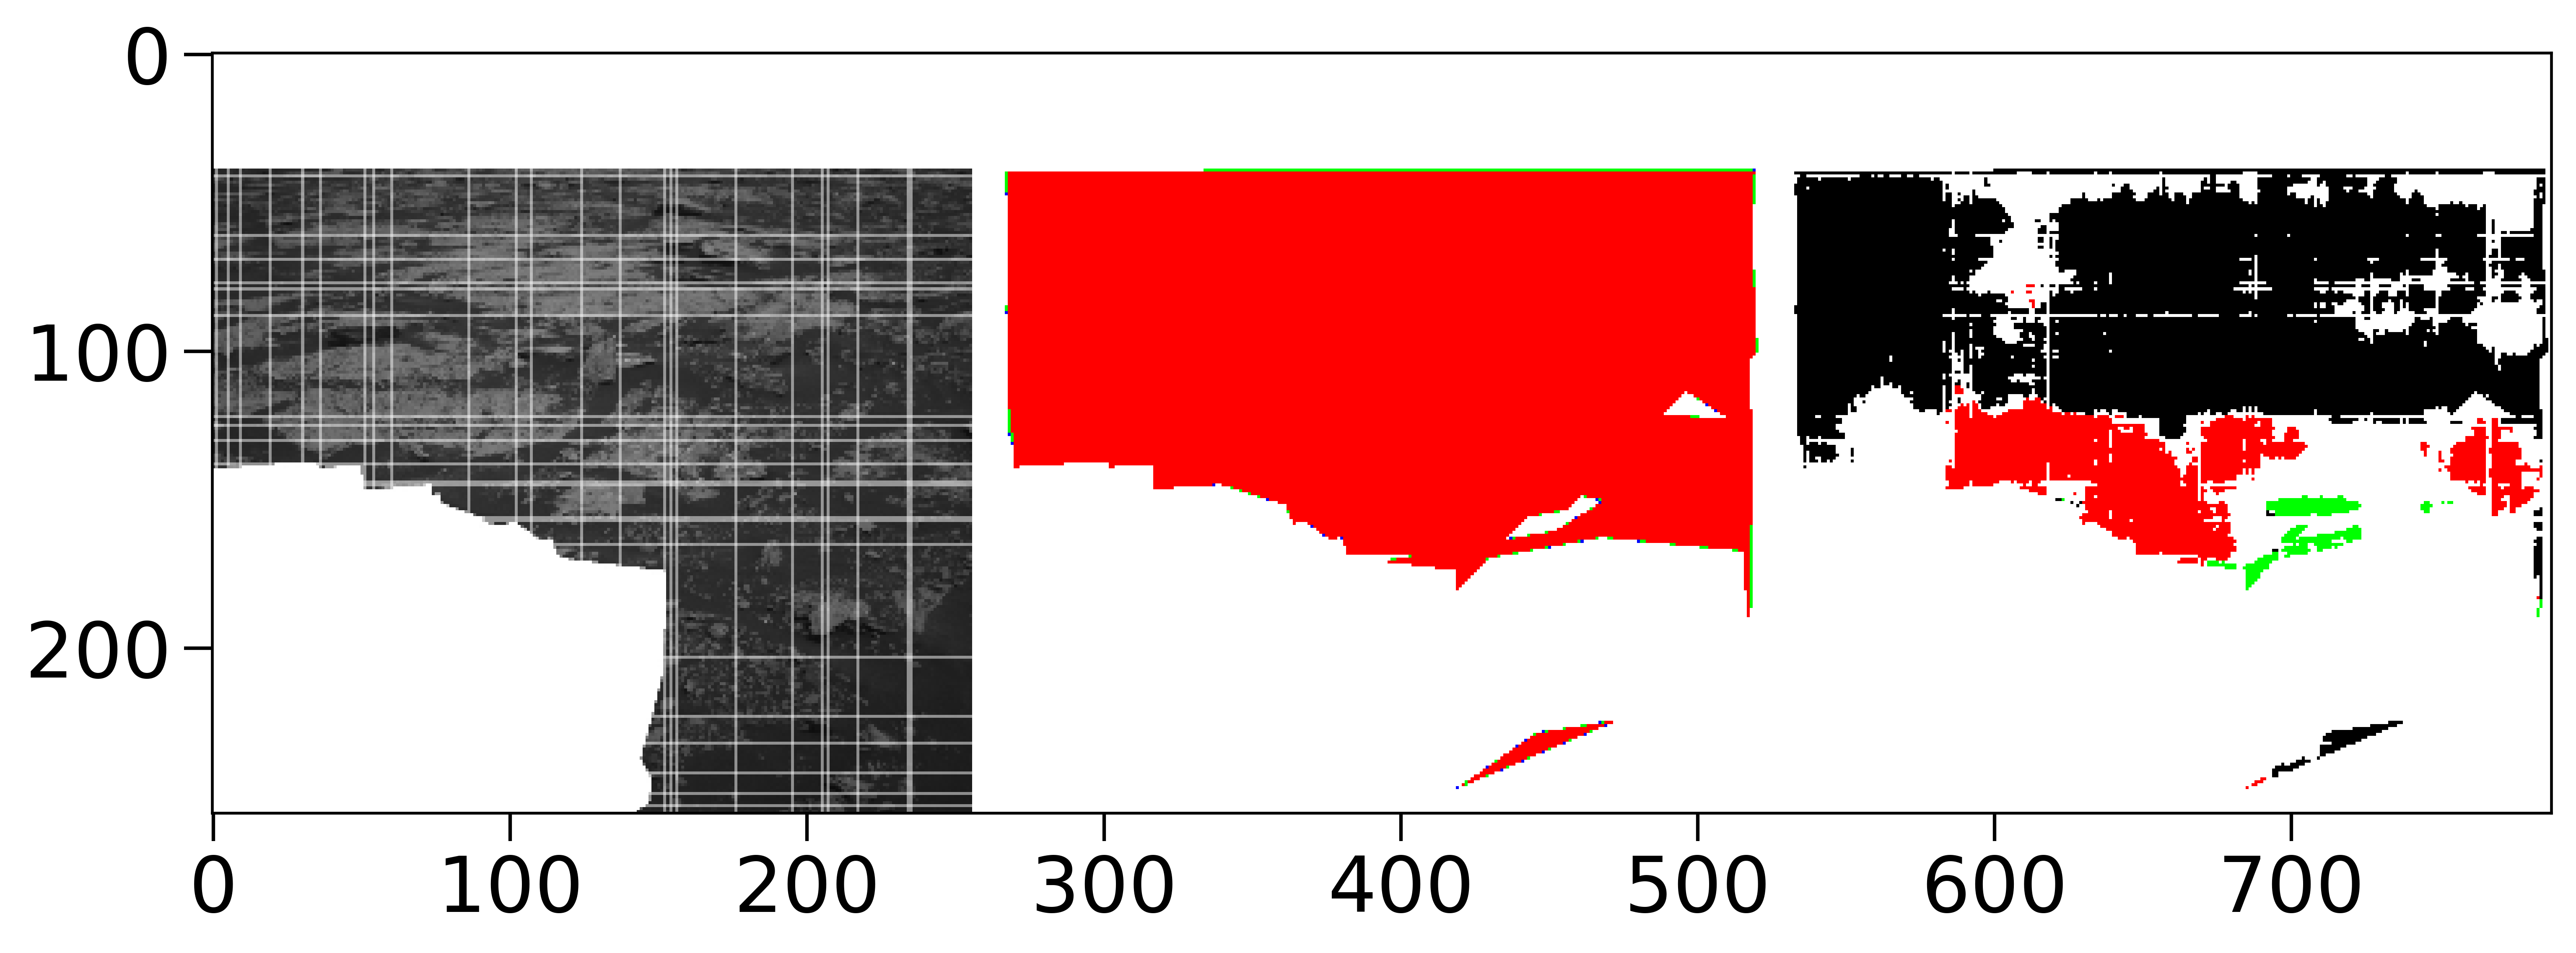

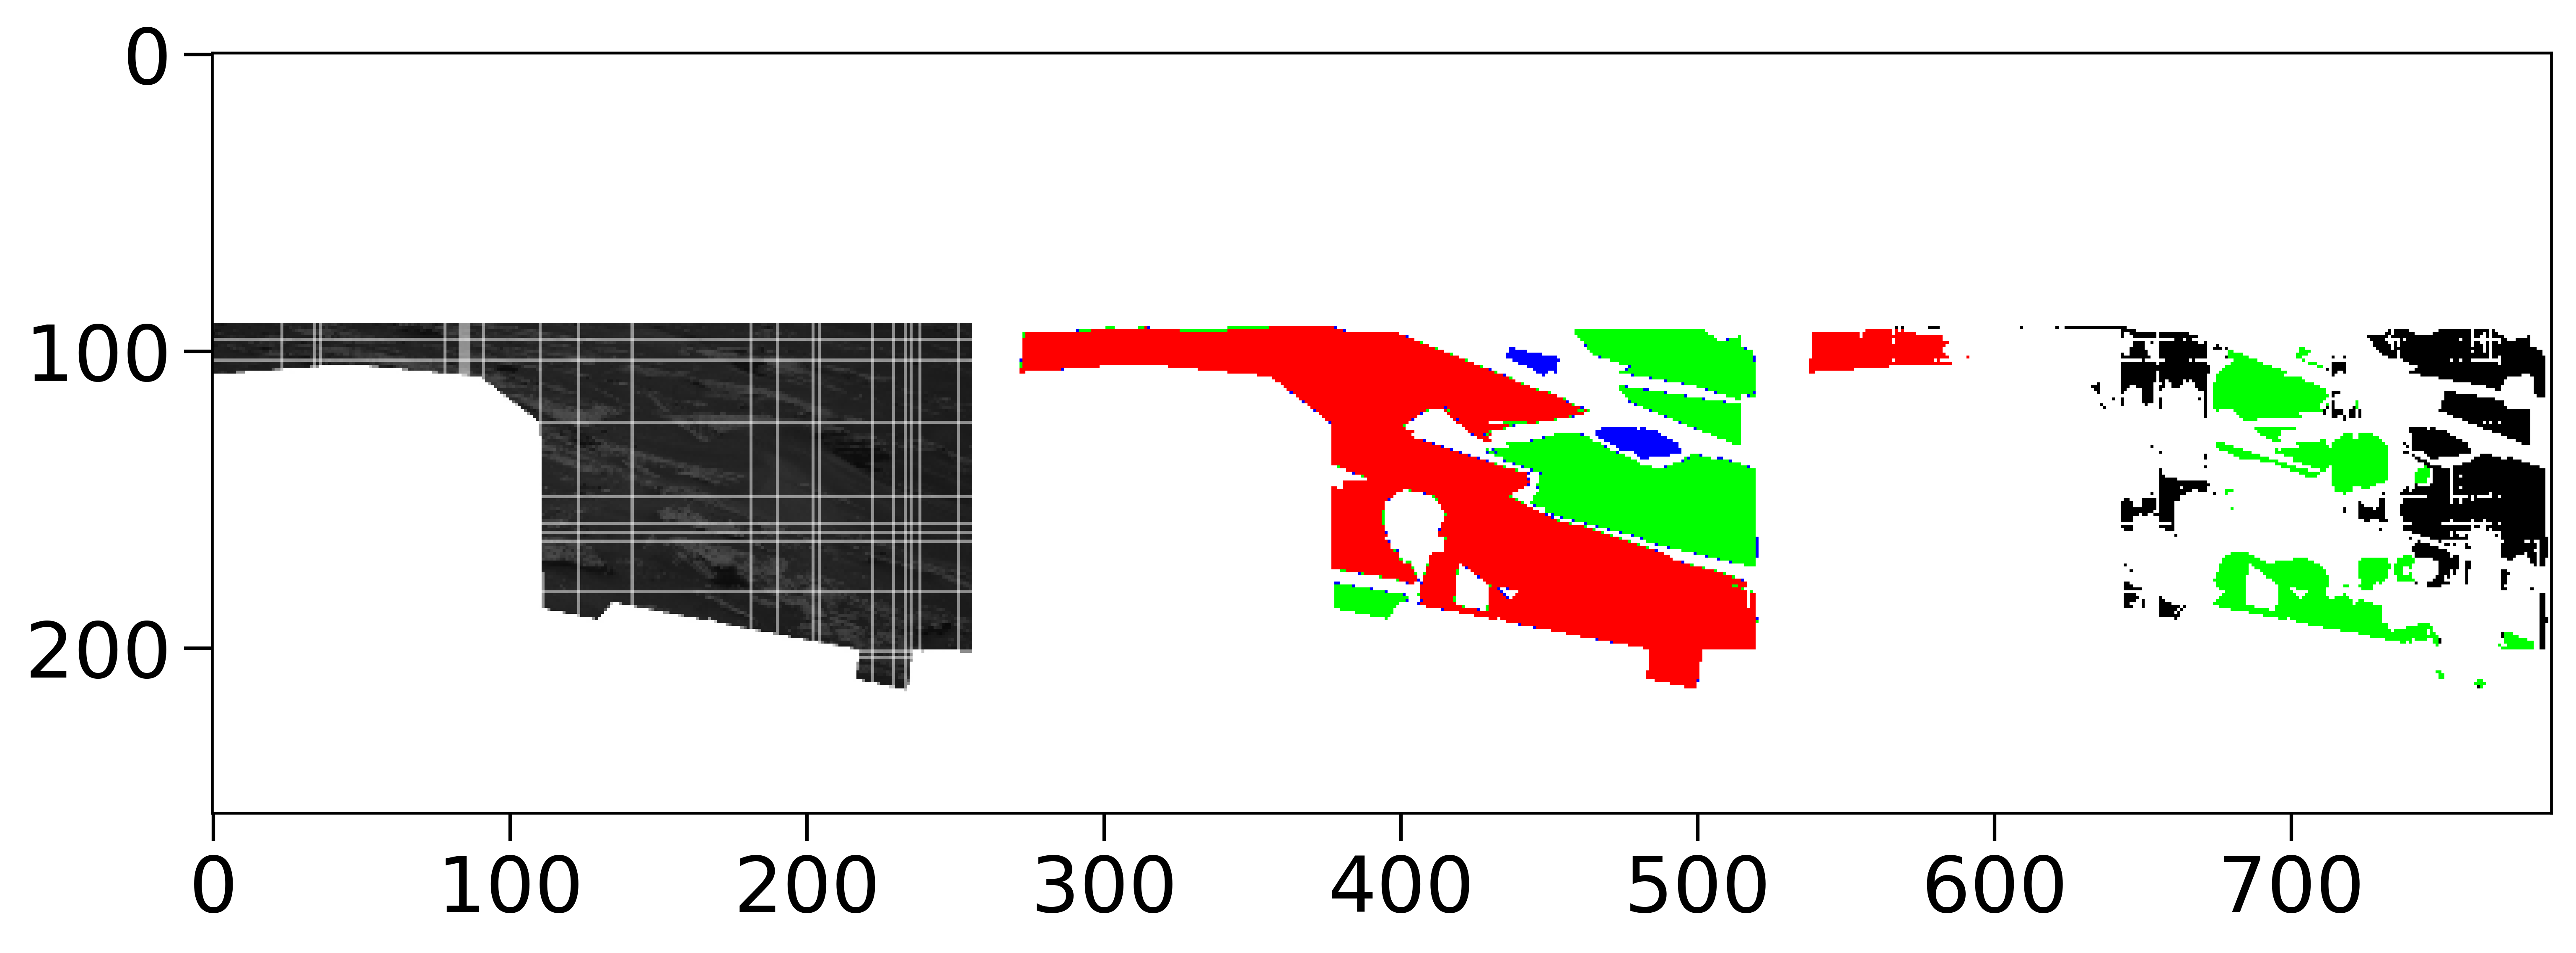

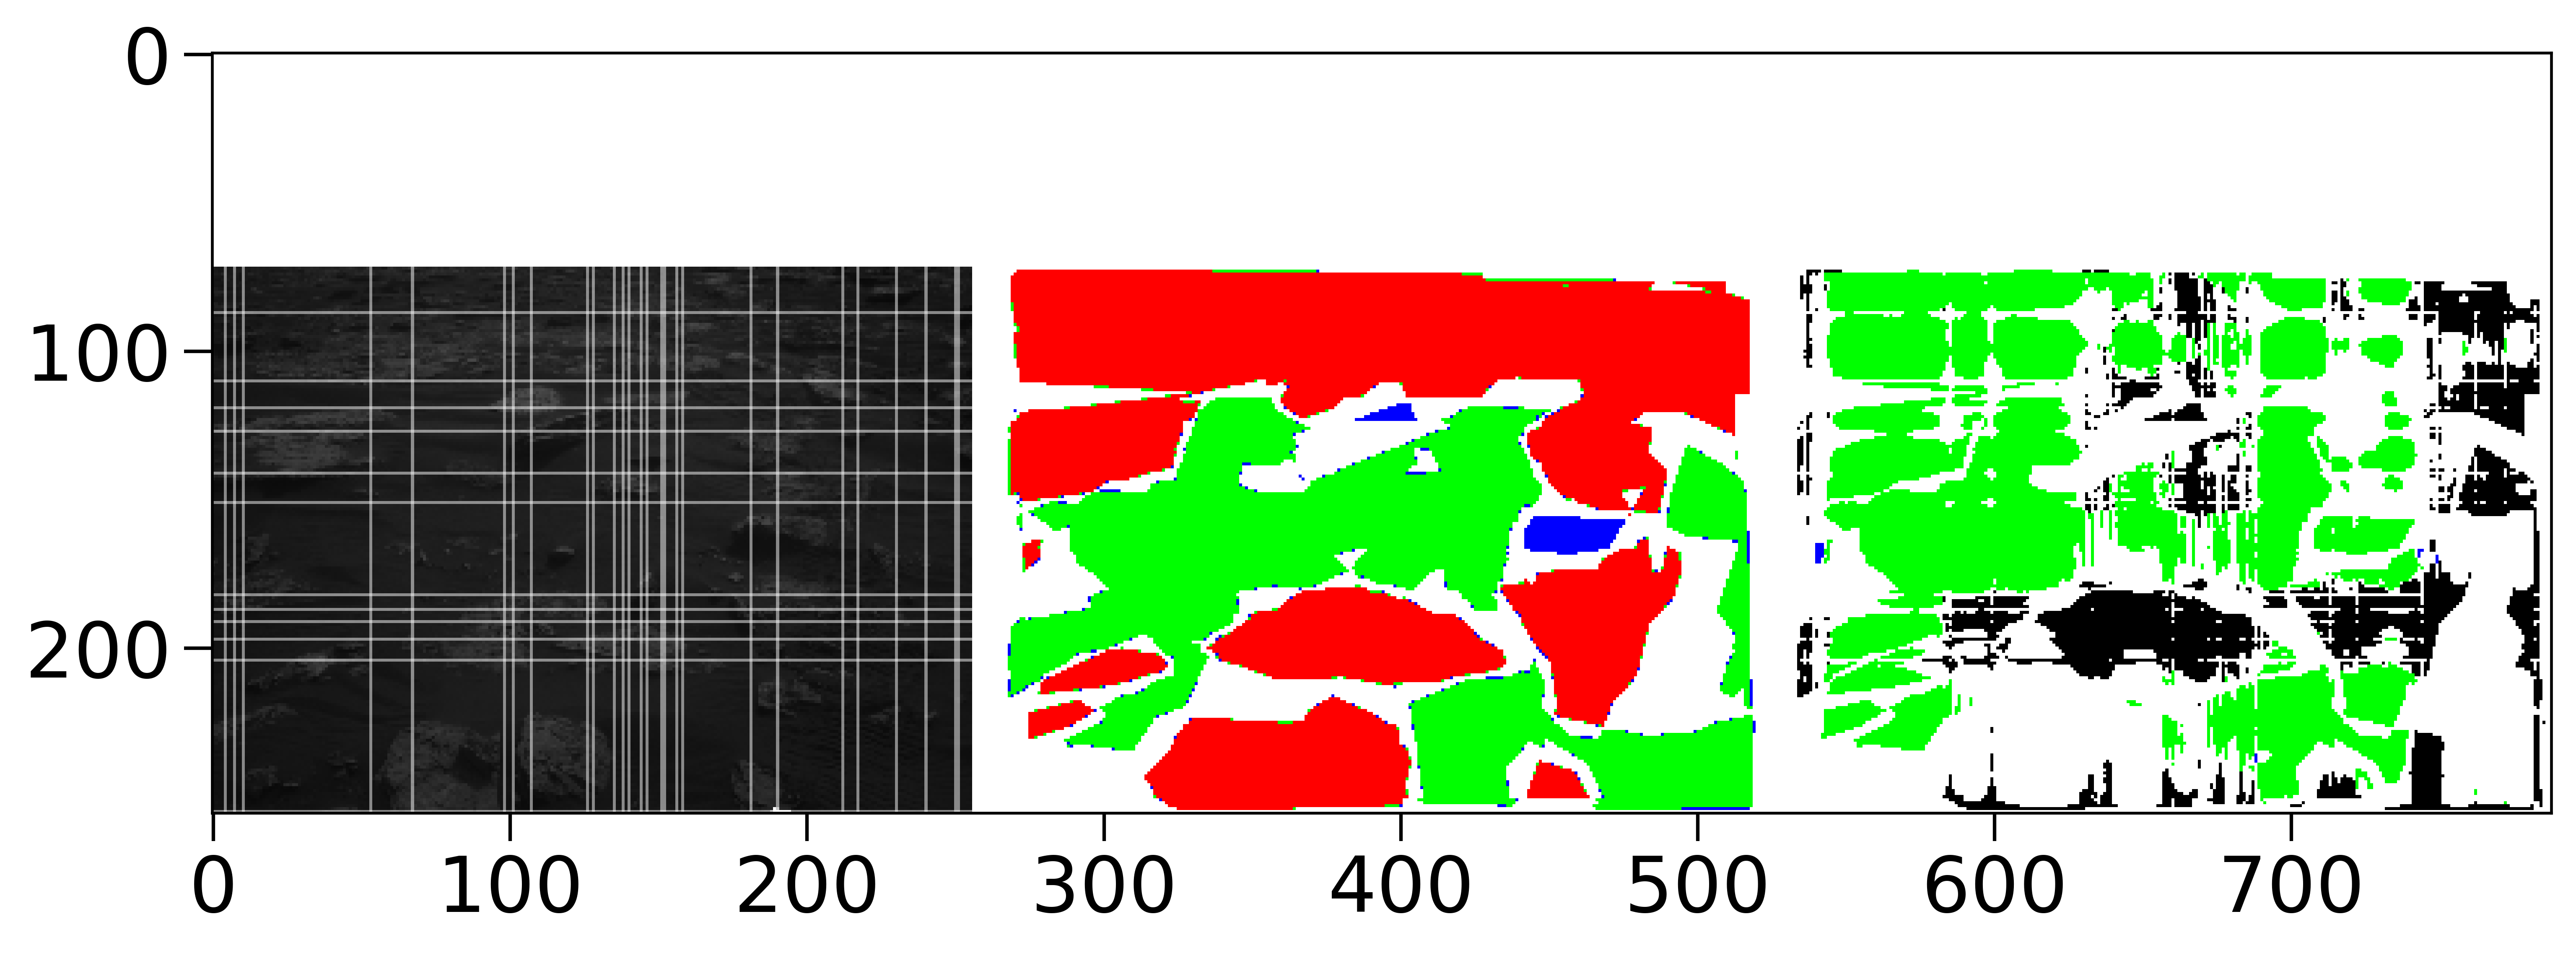

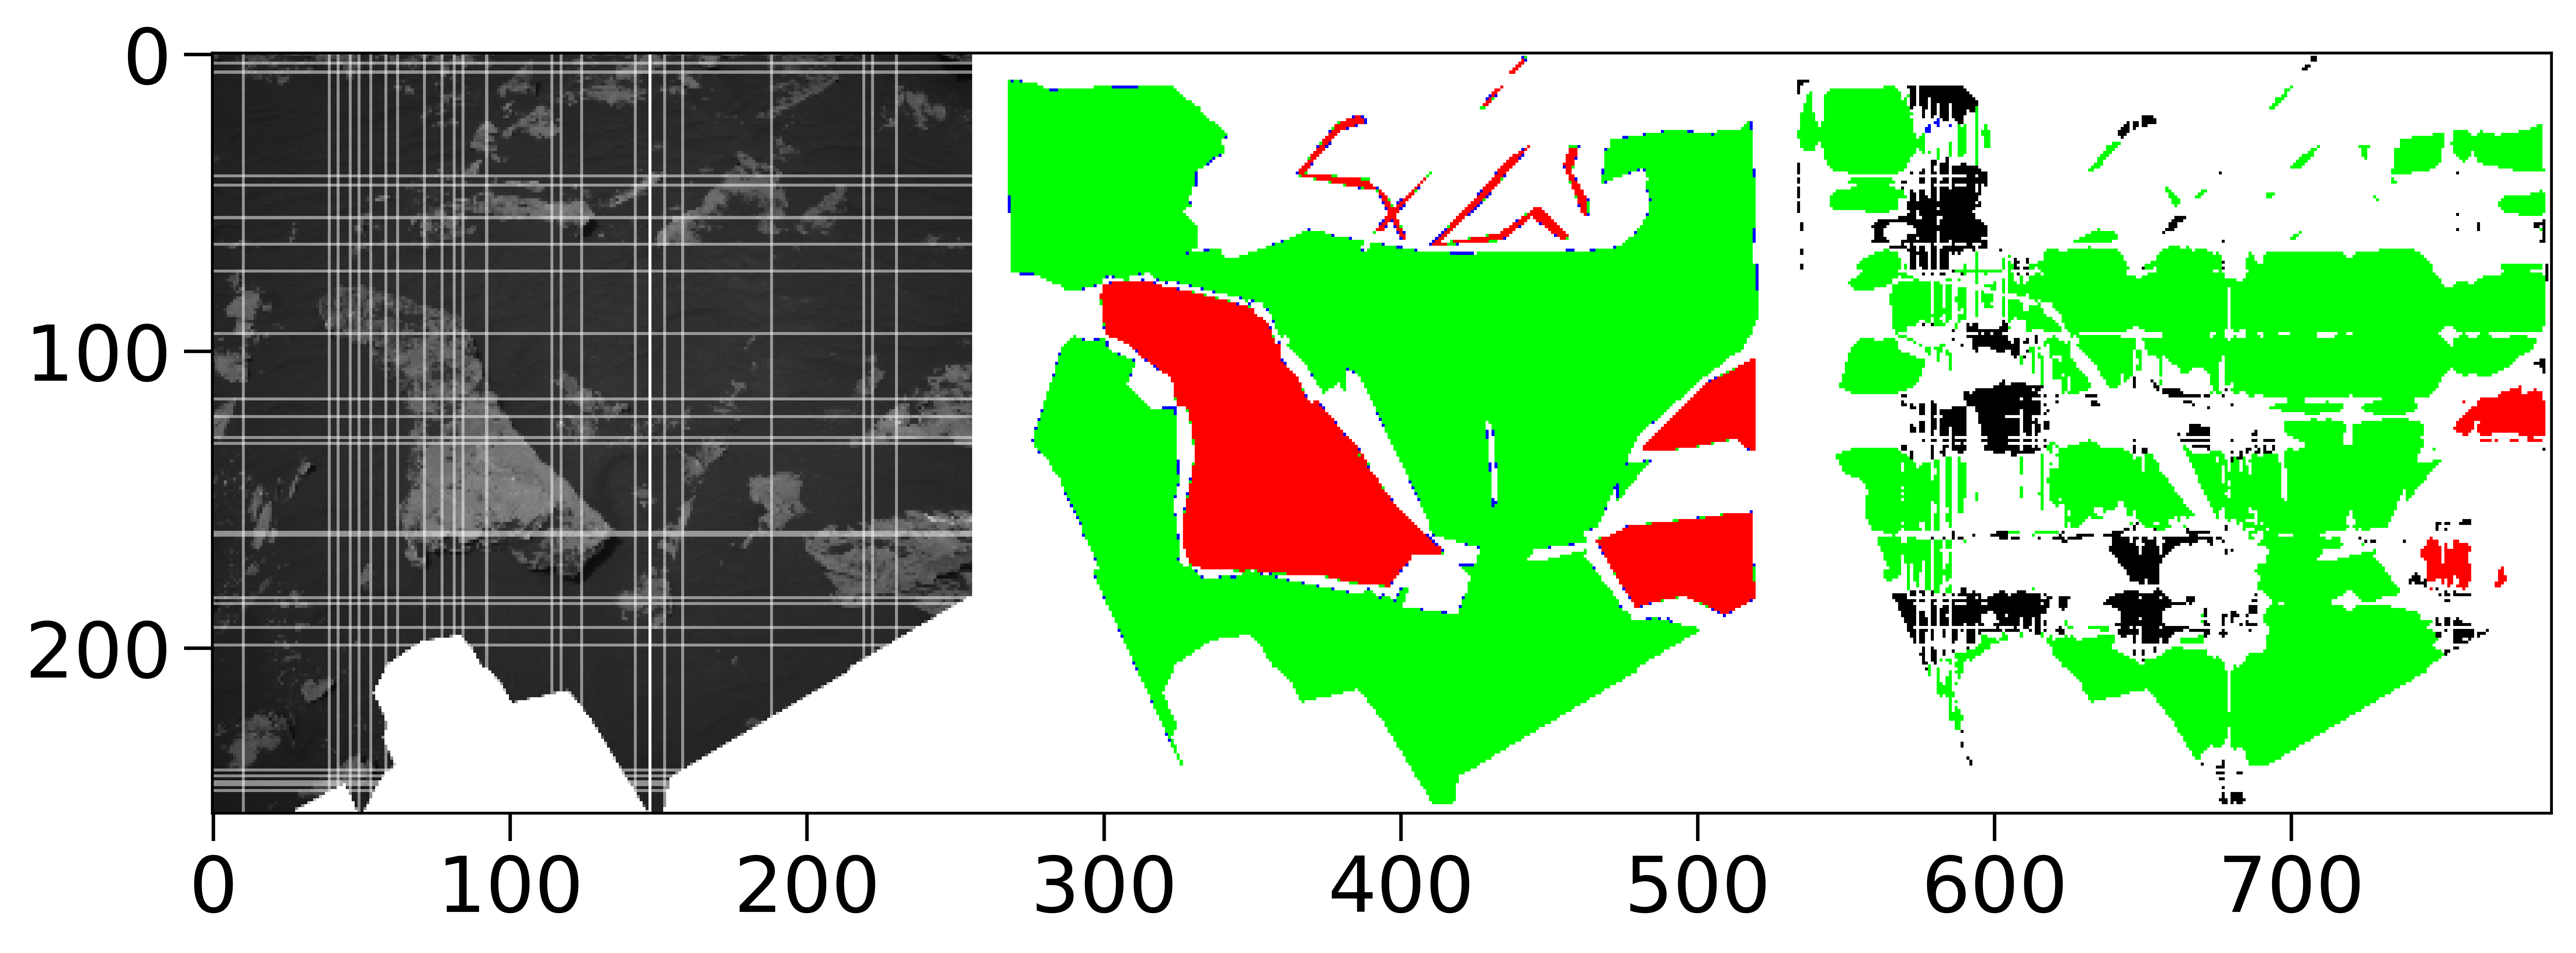

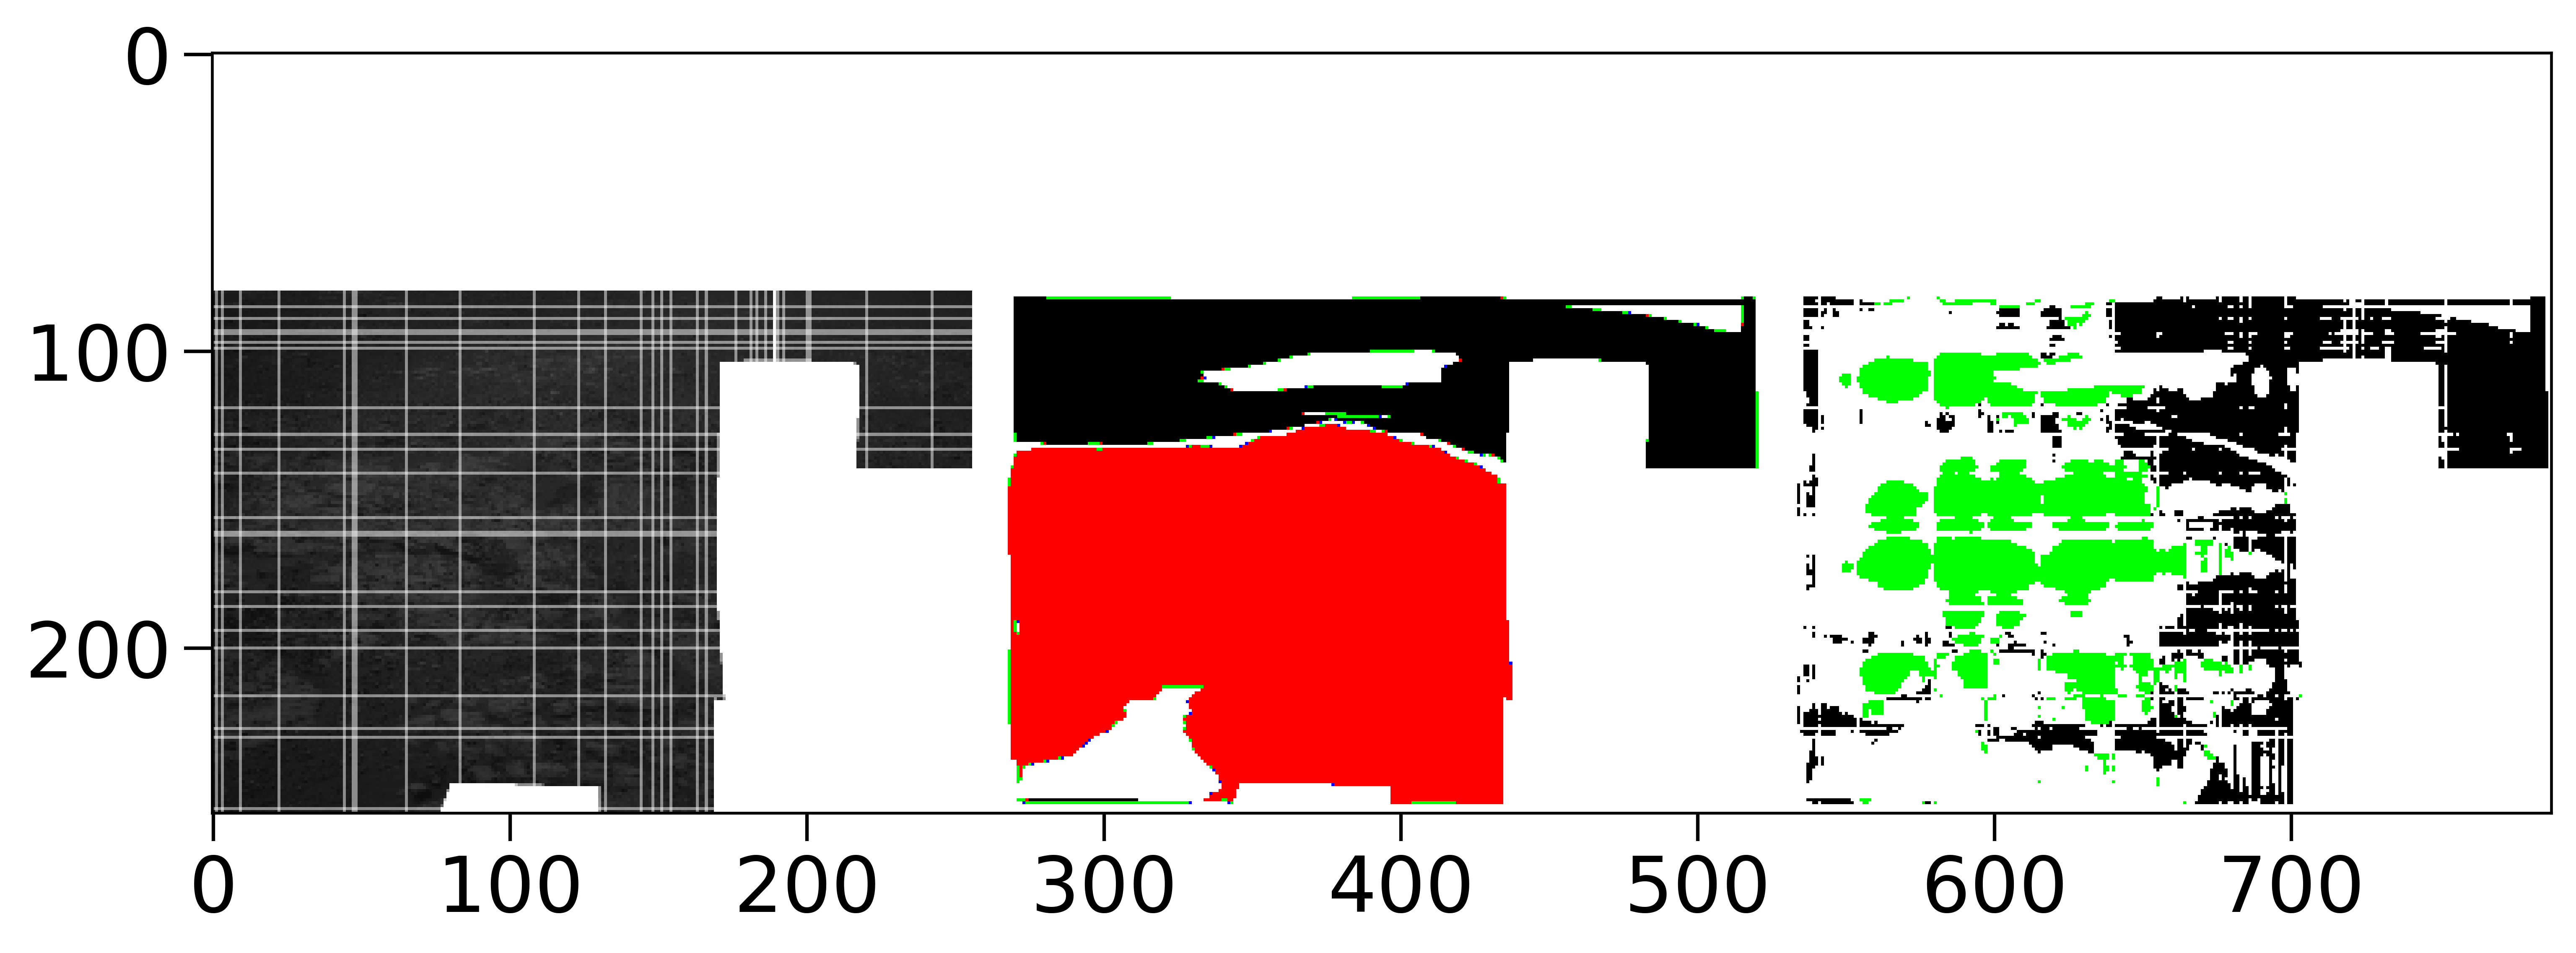

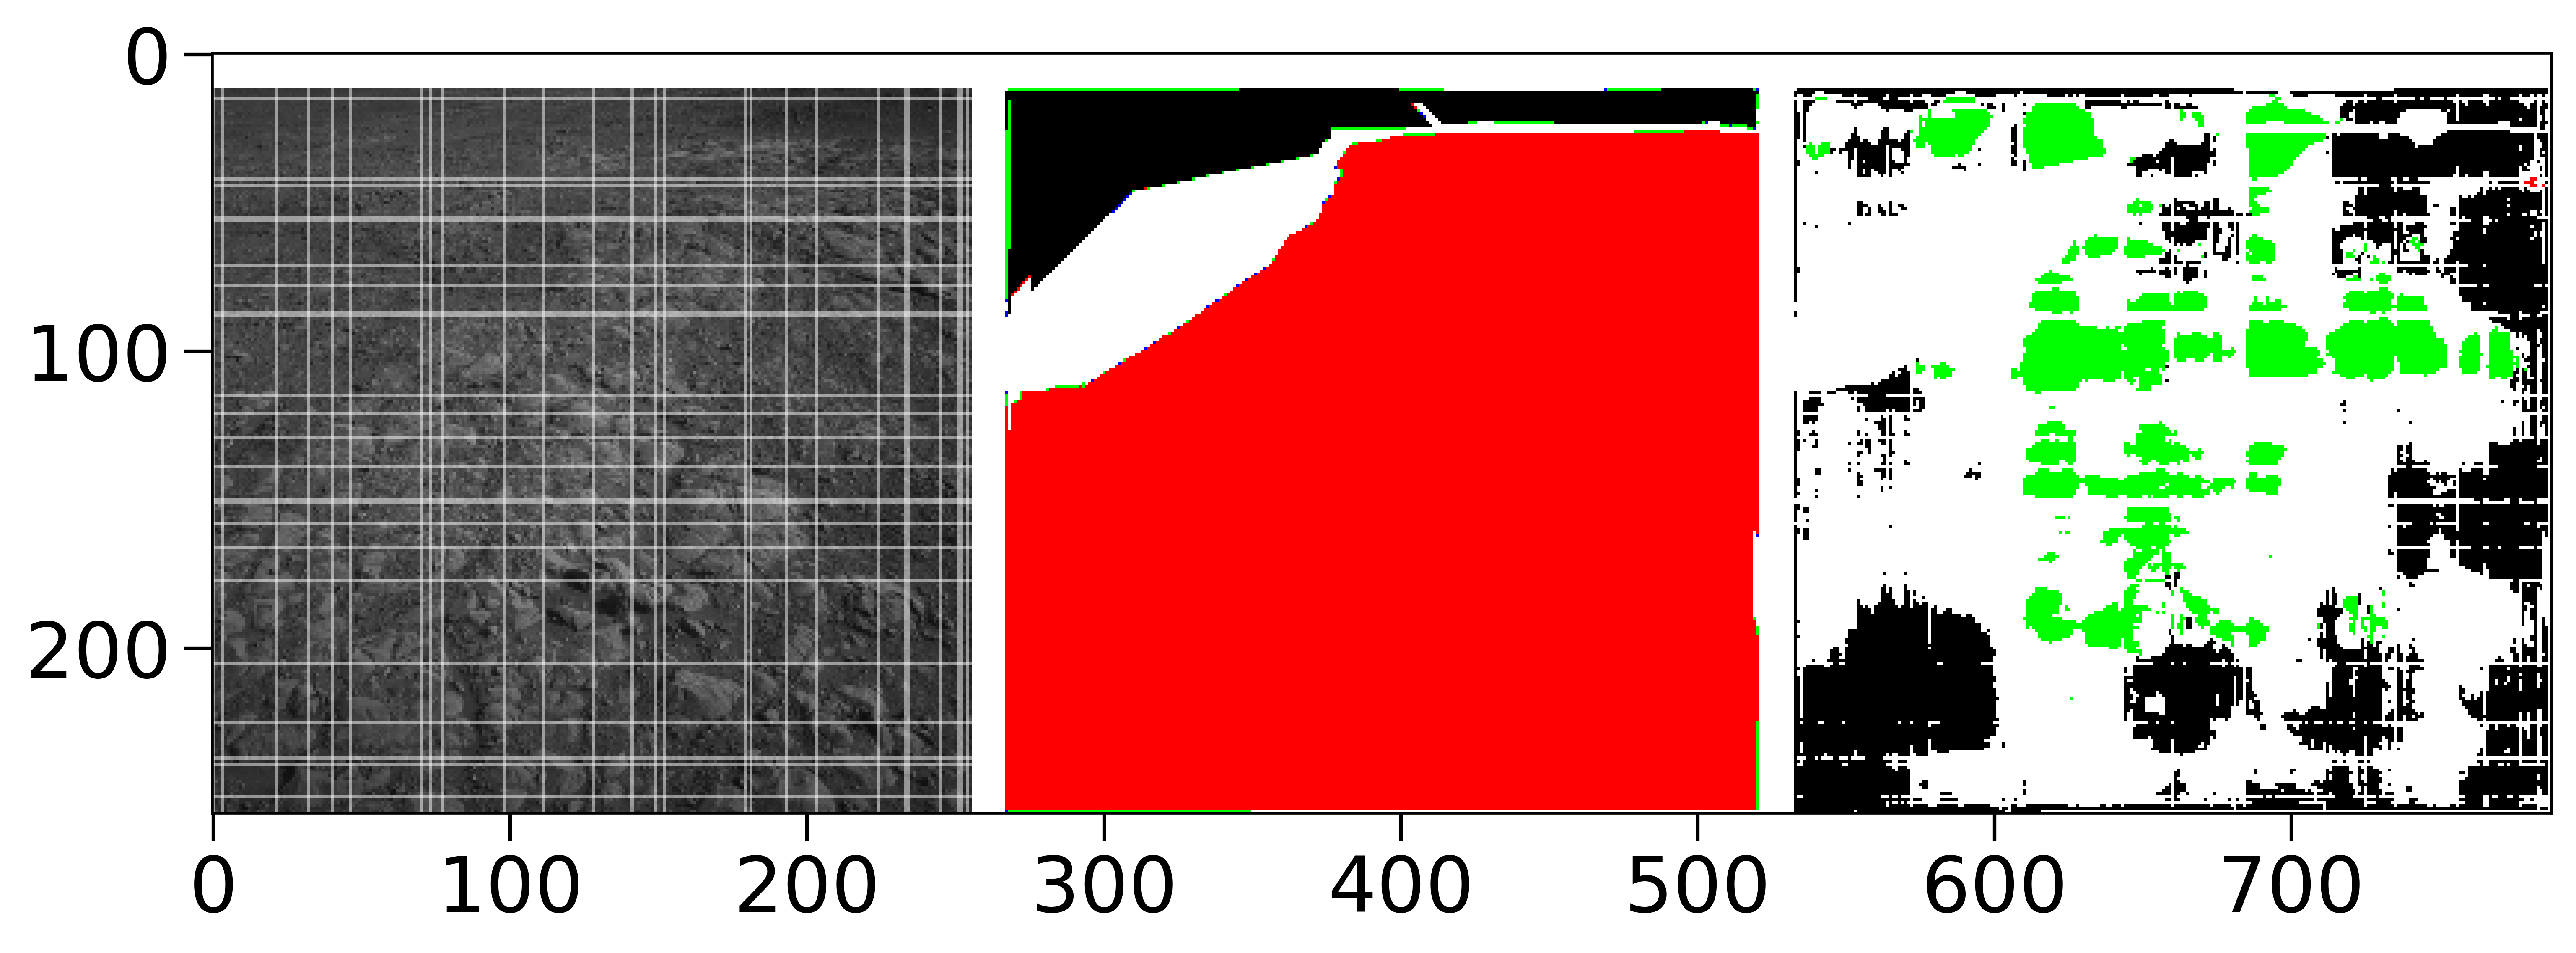

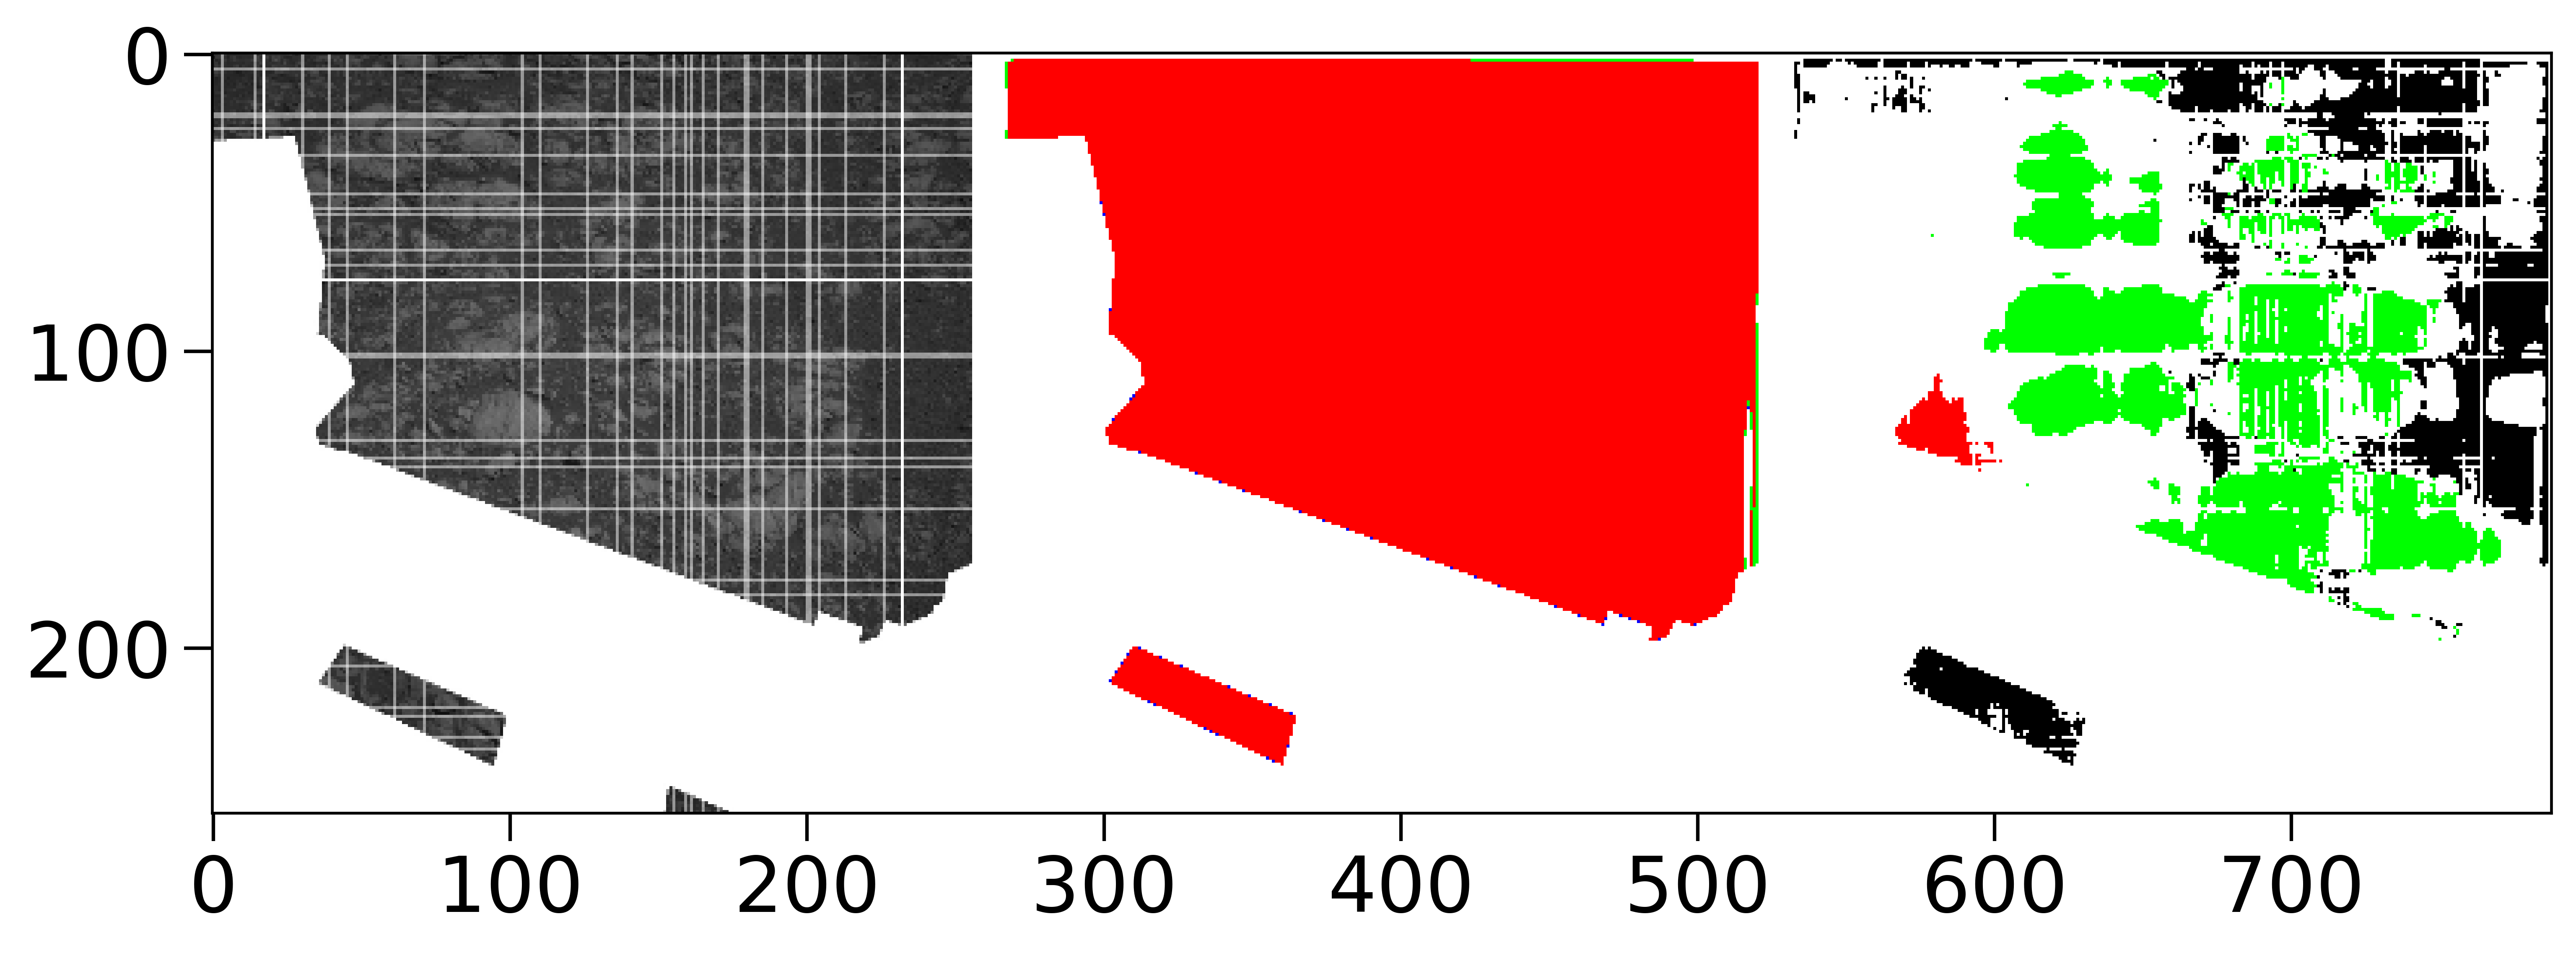

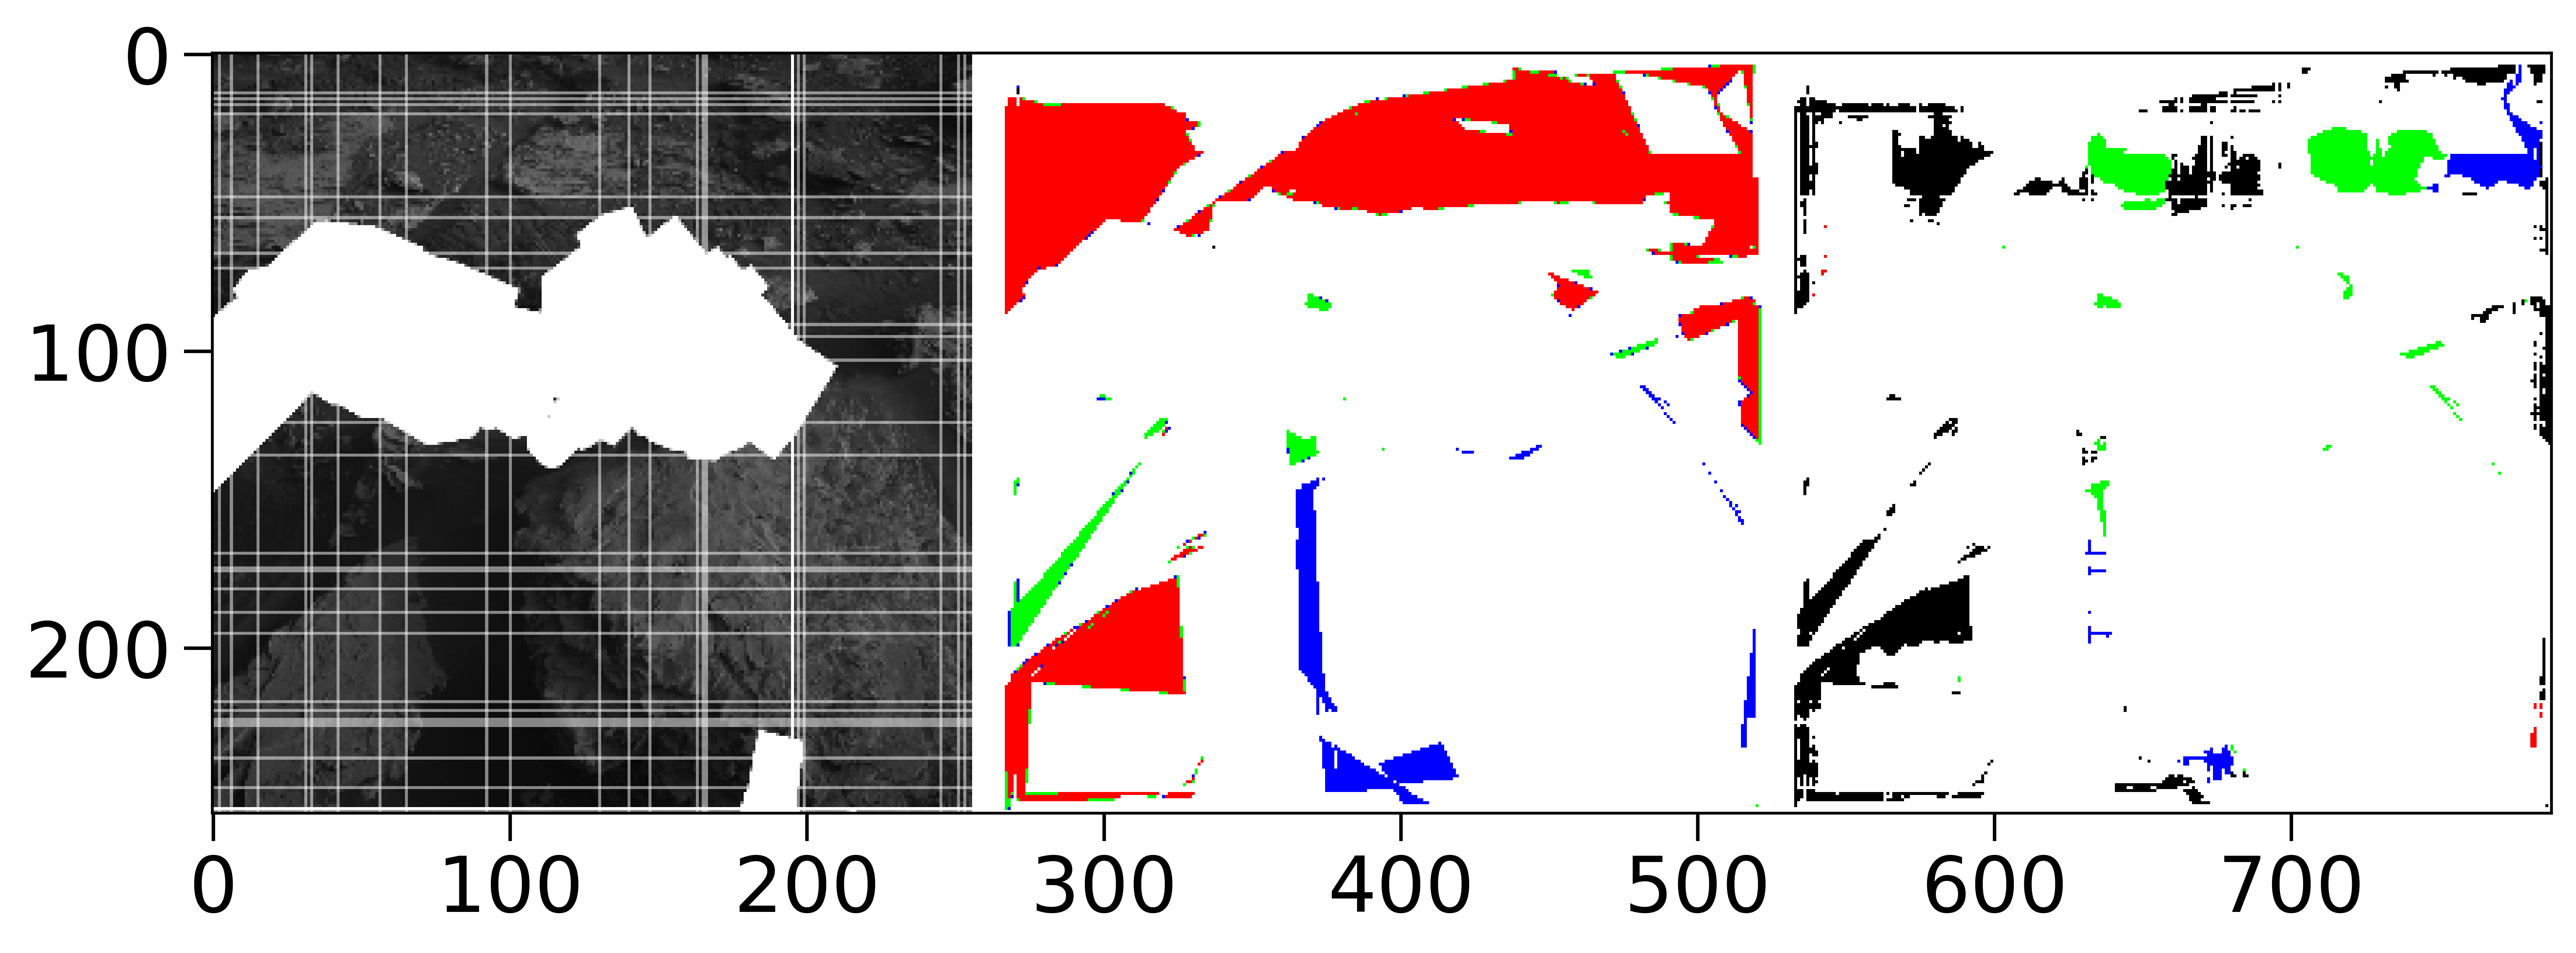

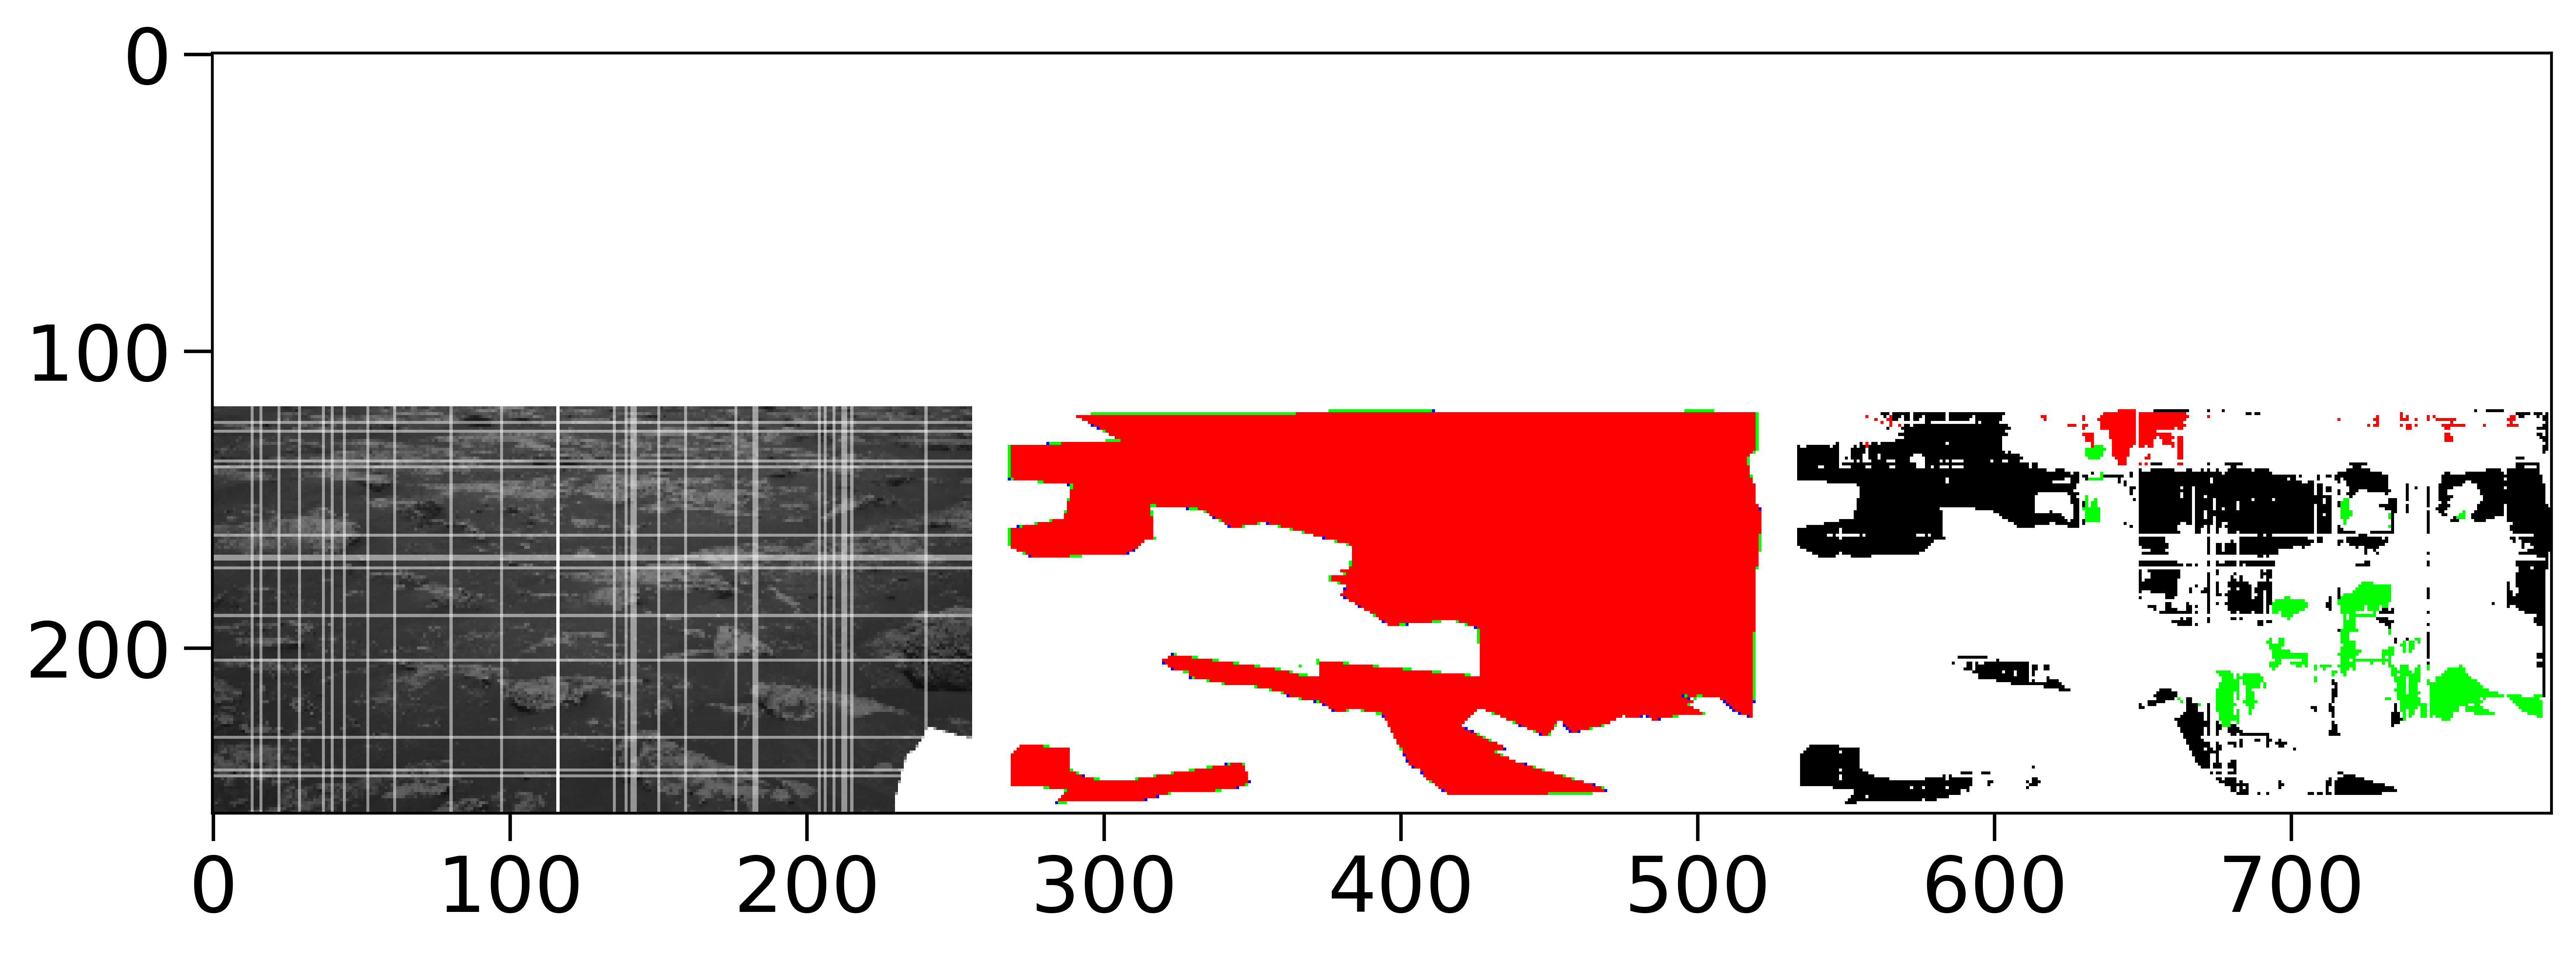

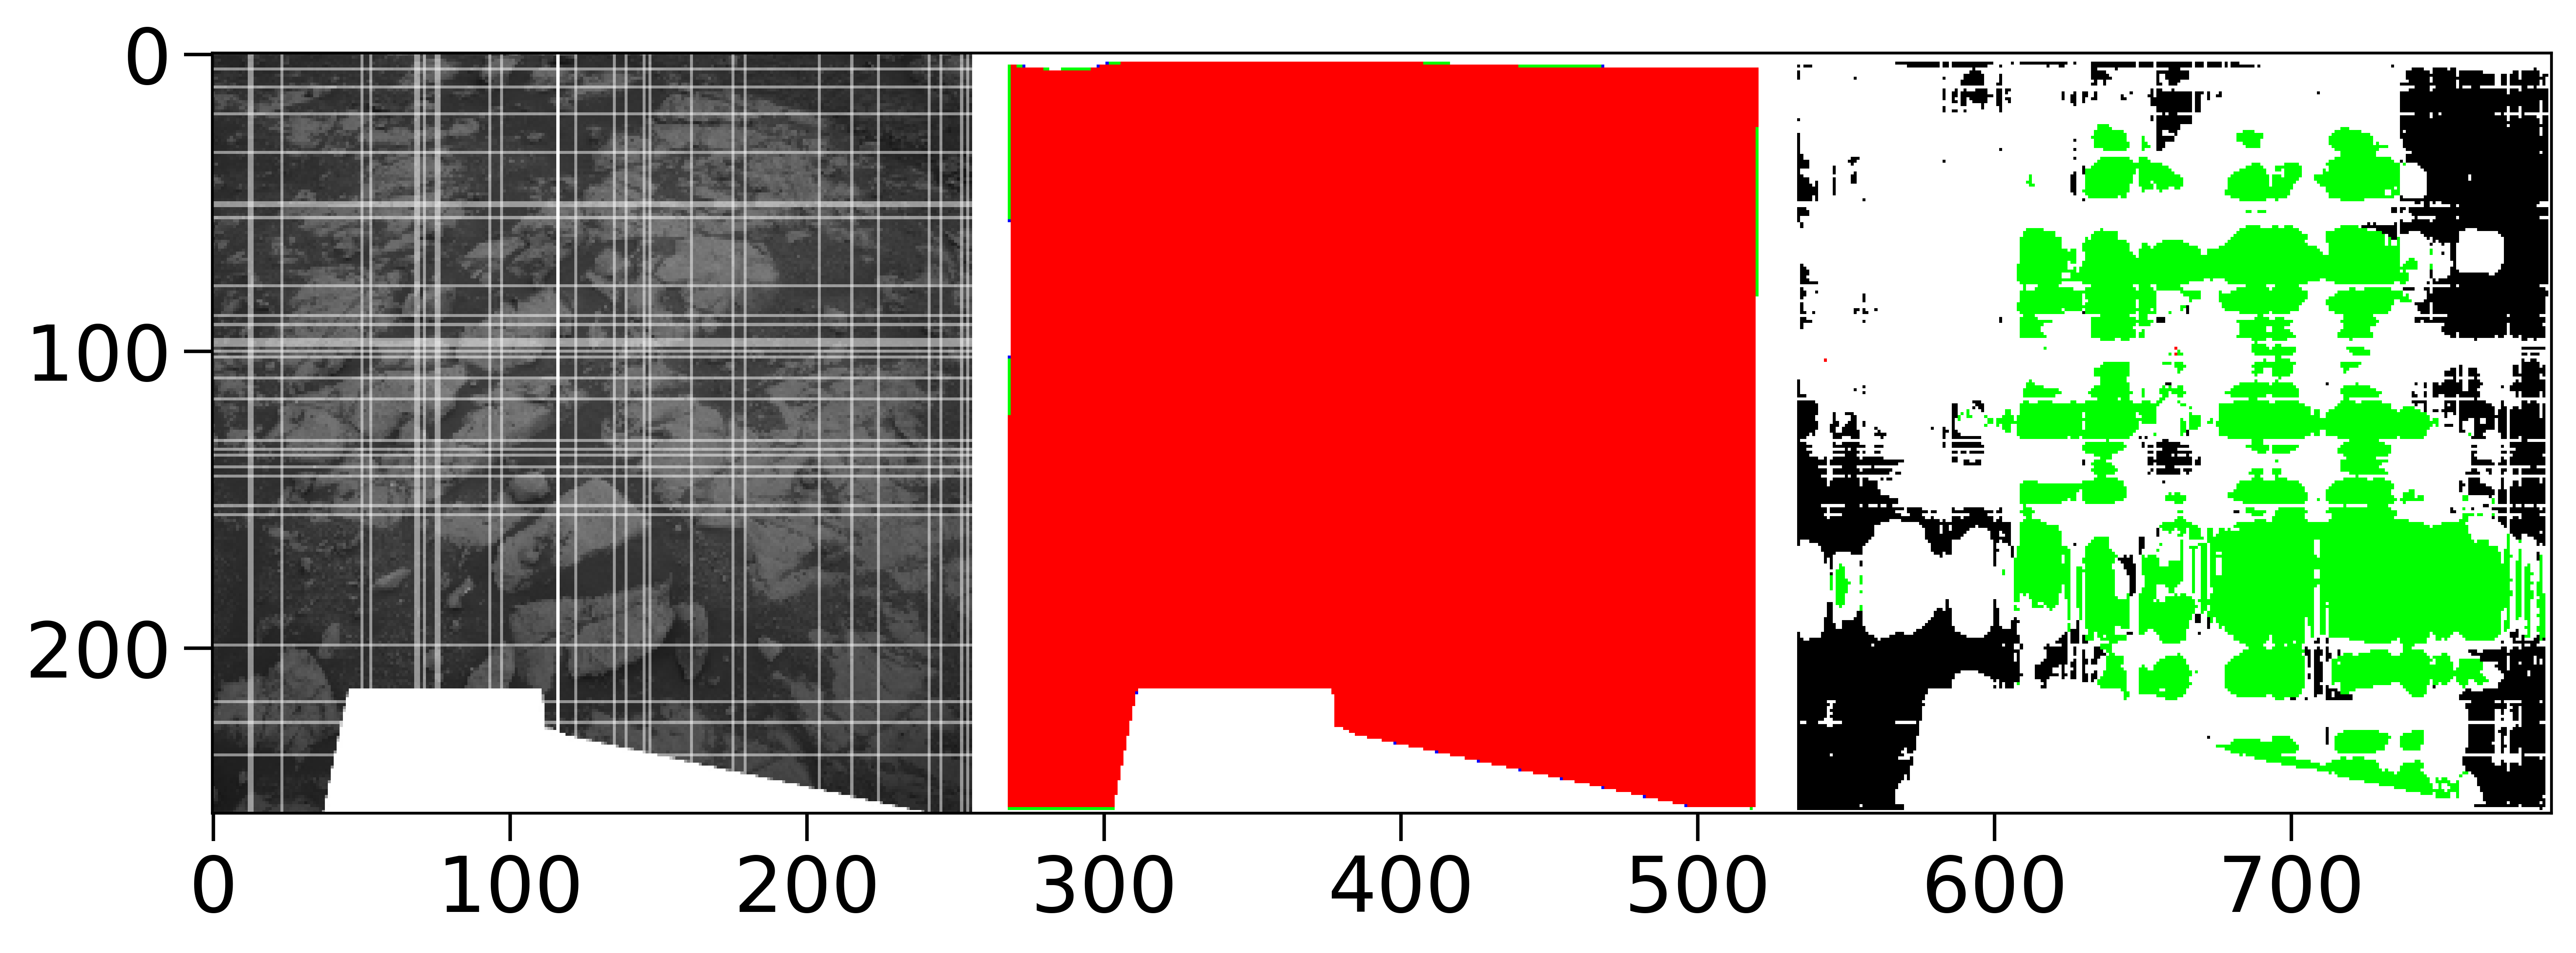

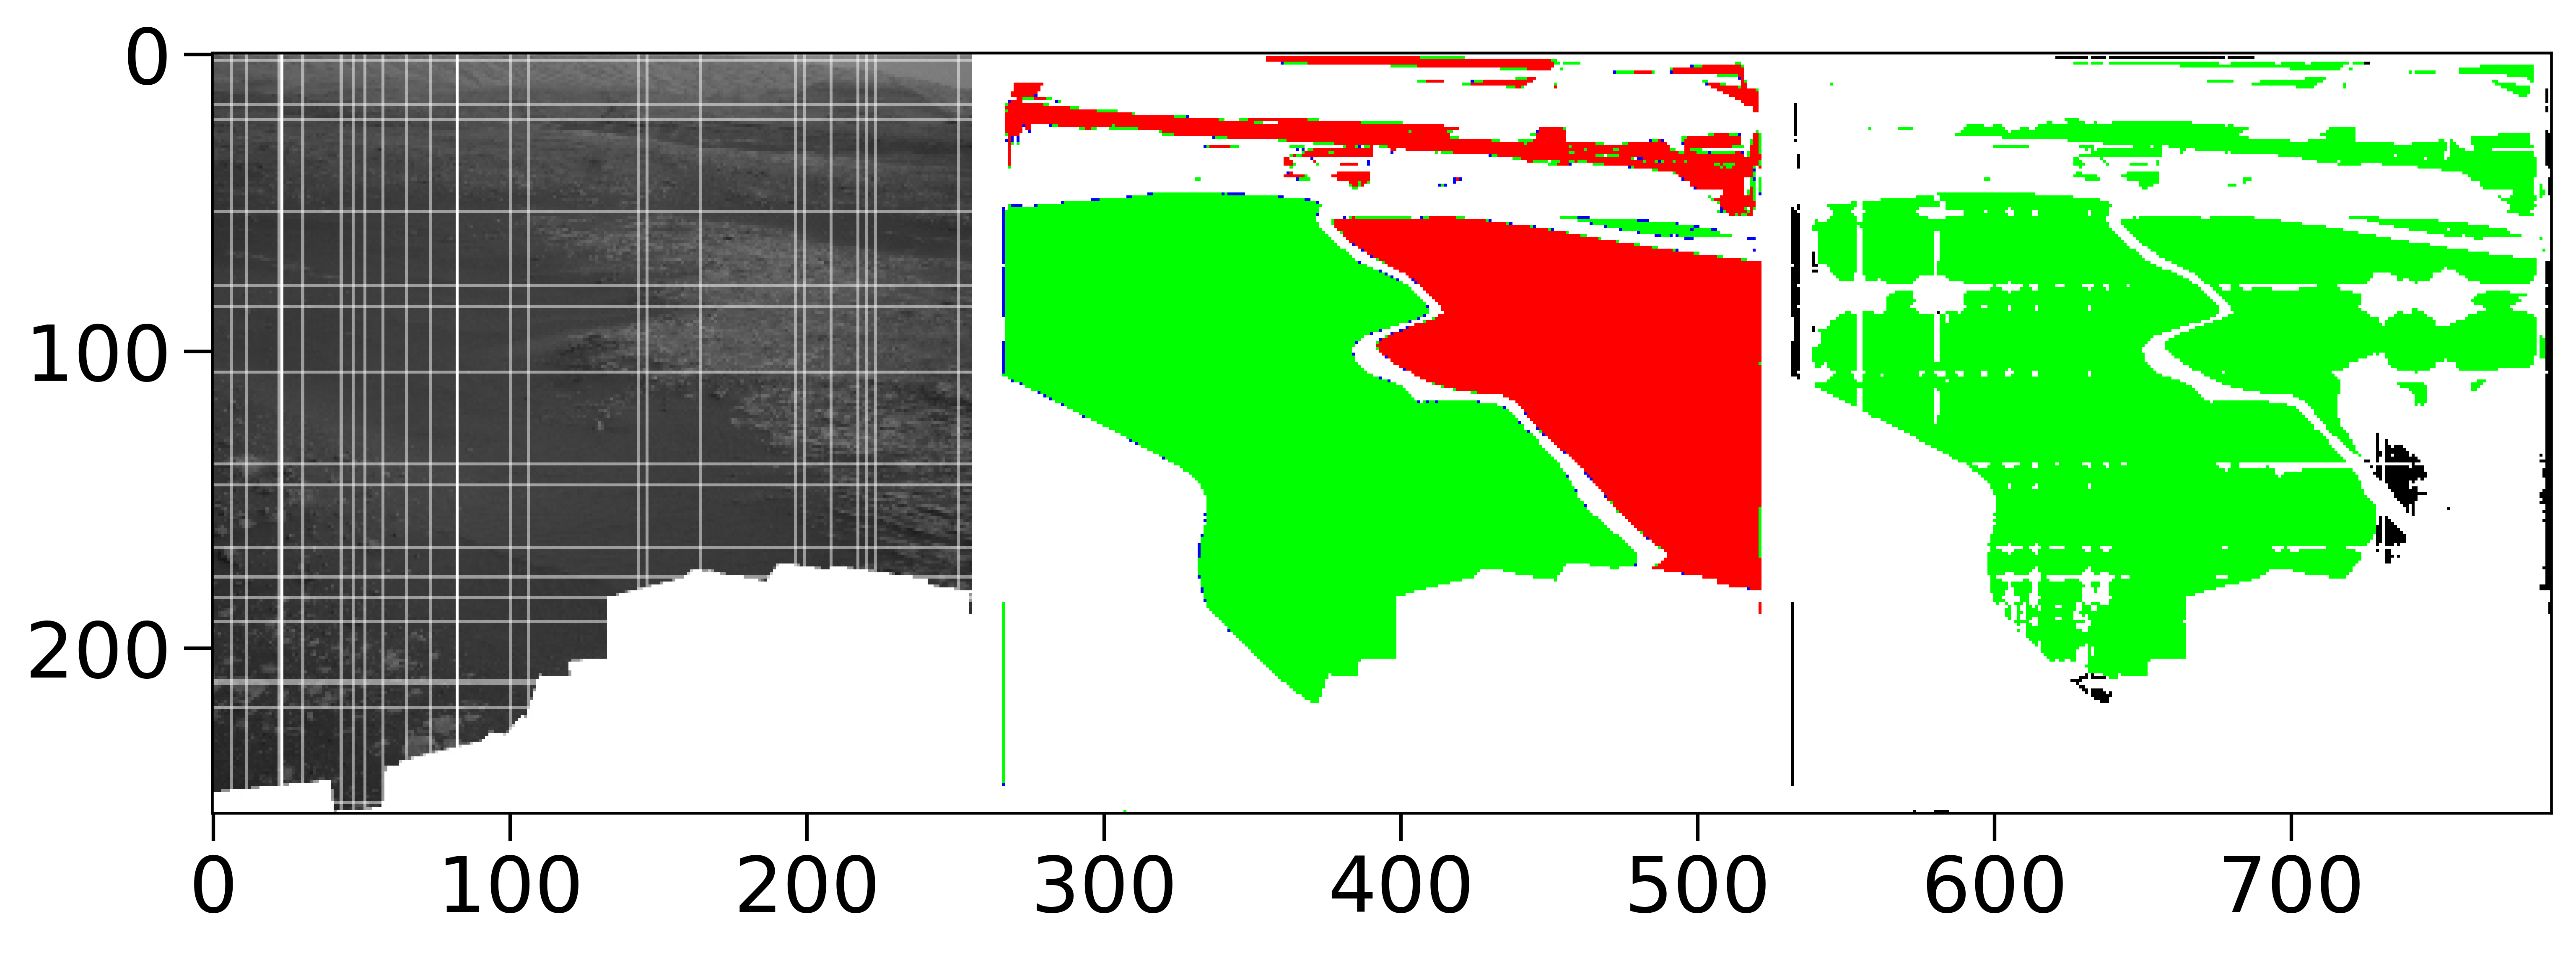

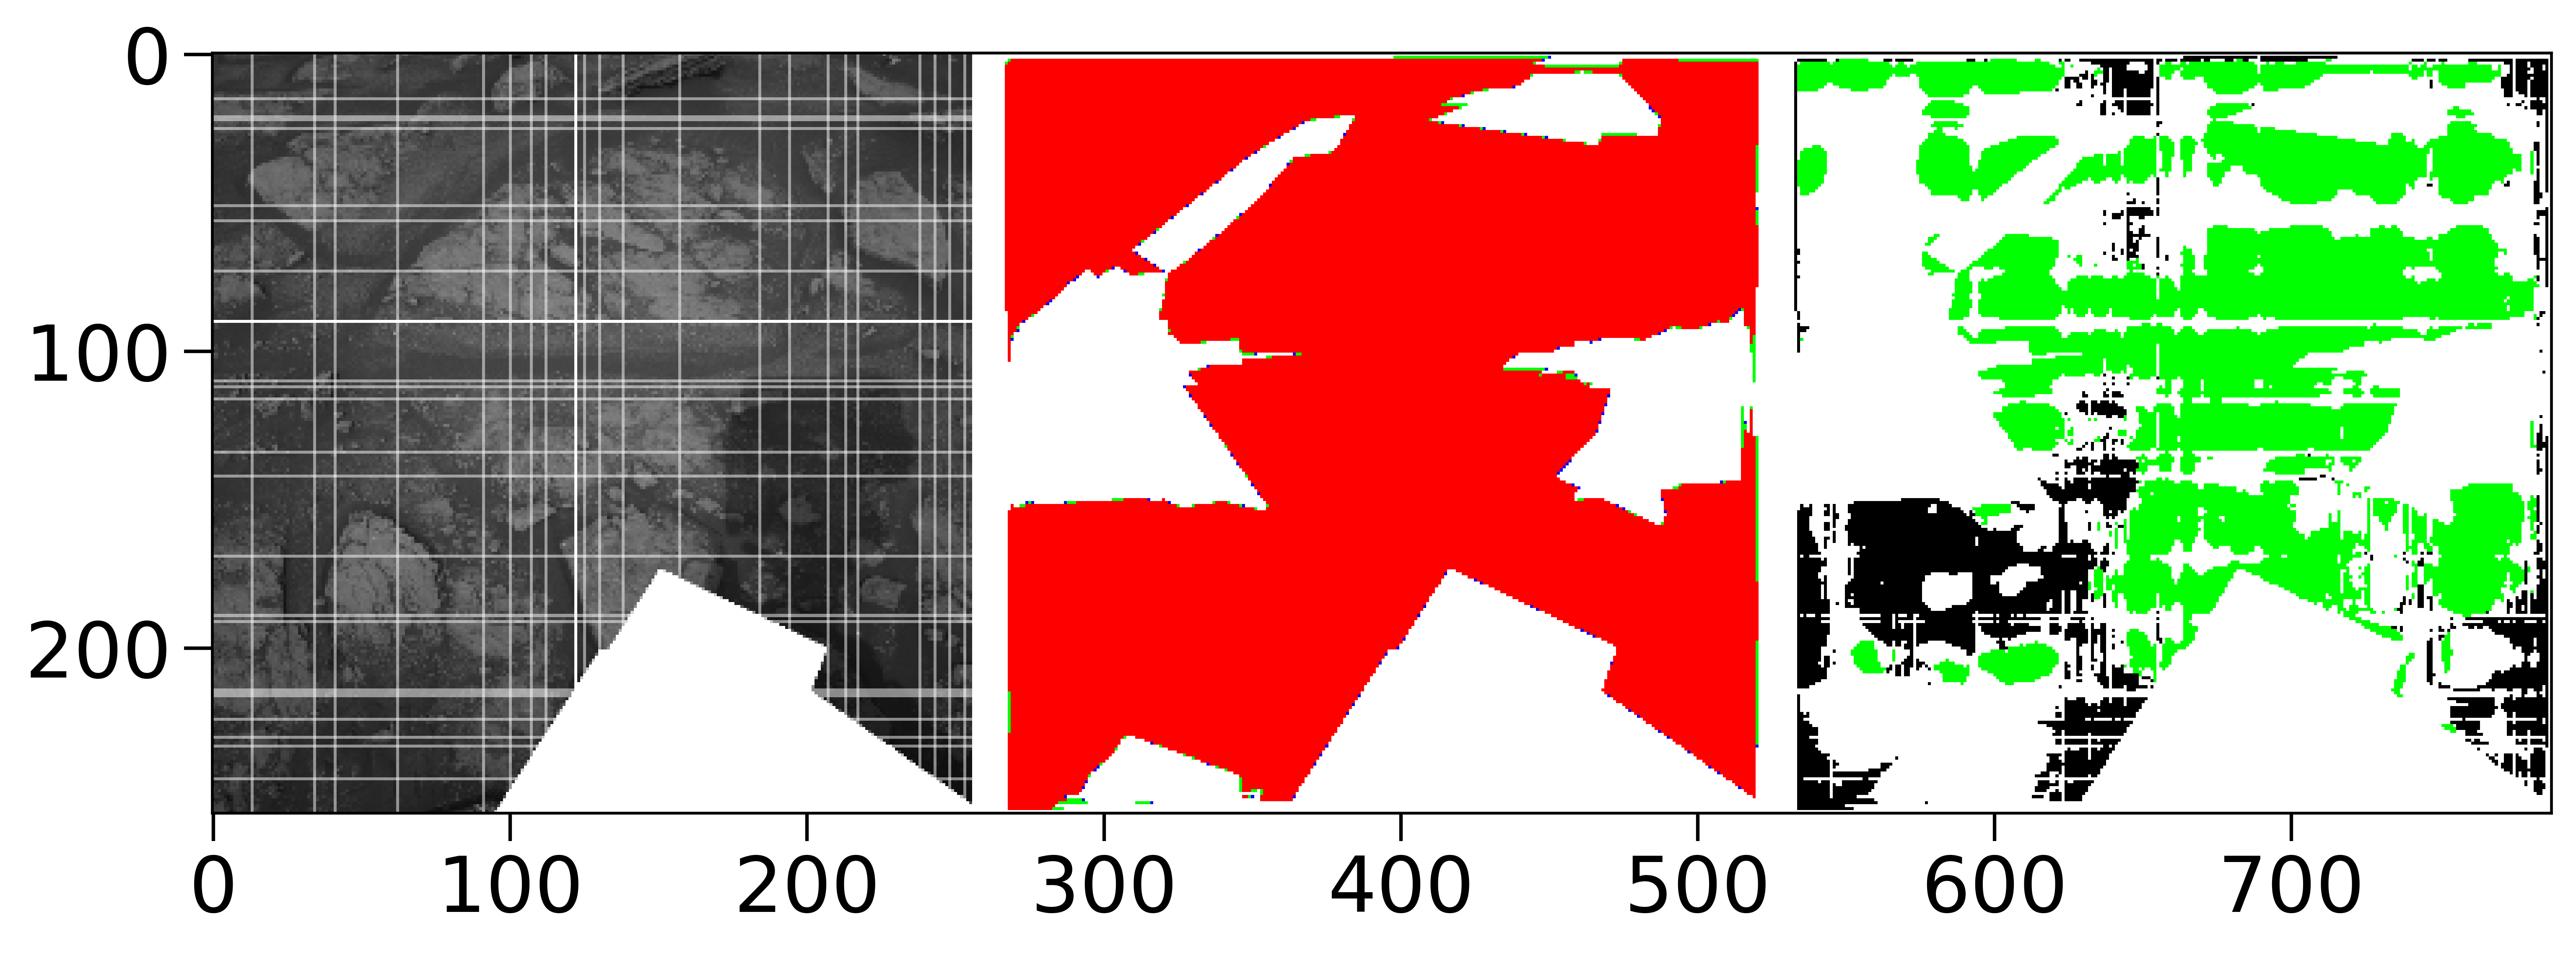

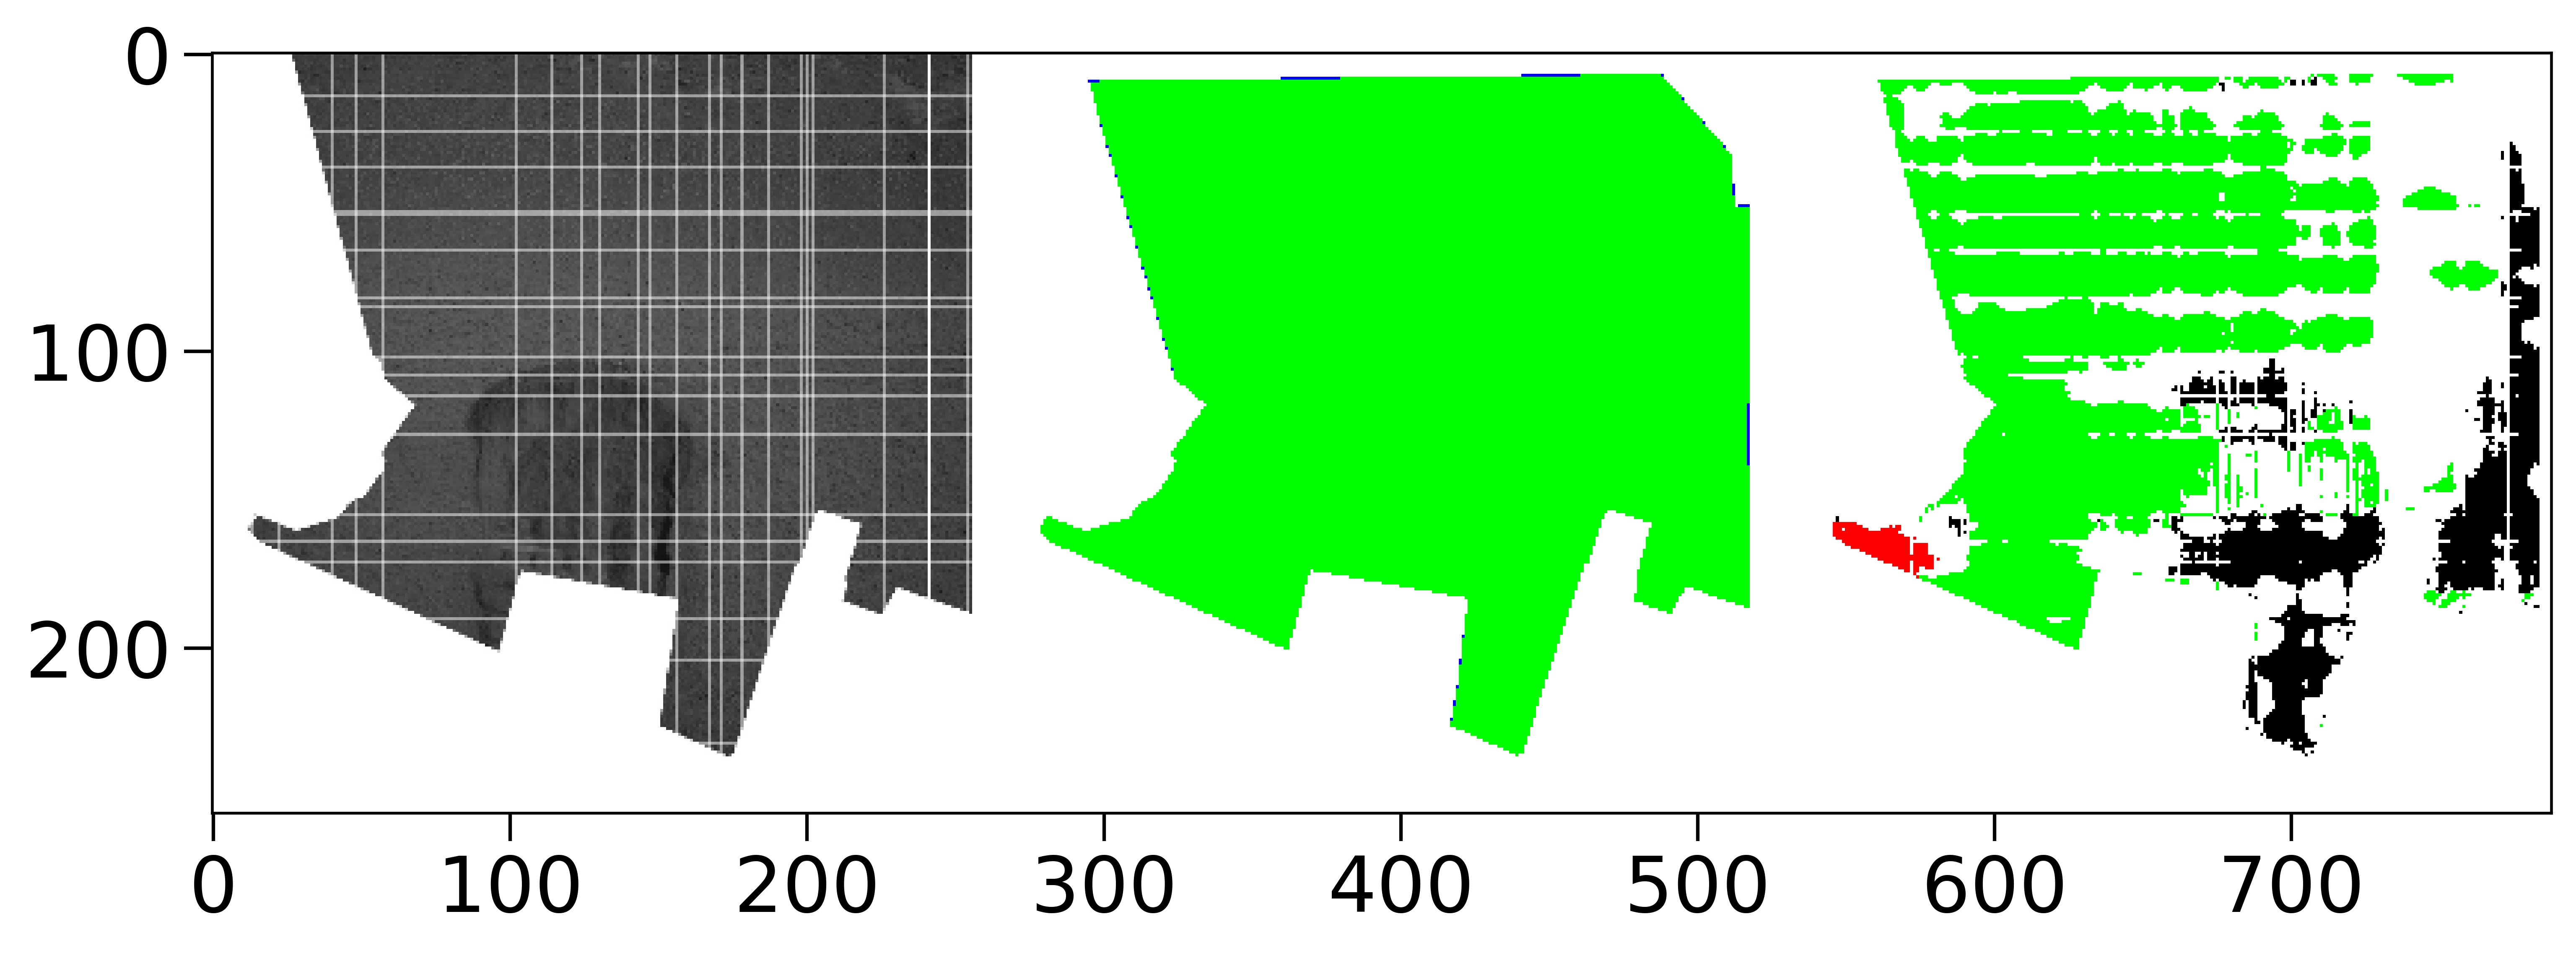

In [8]:
Dice_coef_arr = []
TESTX, TESTY = load_data2(PATH)
for i, (x, y) in enumerate(zip(TESTX, TESTY)):
    x = read_image2(x)
    y = read_mask2(y)
    y,a = fixup(y)
    y = to_rgb(y)
    y_pred = multipred(x)
    y_pred = to_rgb(y_pred)
    y_pred[a,:] = [1,1,1]

    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        y, white_line,
        y_pred
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)
    plt.savefig(os.path.join(PATH, OUT[:-1] + str(i) + ".png"),bbox_inches='tight')
    dice = dice_coef(y,y_pred)
    Dice_coef_arr.append(tf.keras.backend.get_value(dice))
    print(tf.keras.backend.get_value(dice))

In [9]:
print(np.mean(Dice_coef_arr))
np.save(os.path.join(PATH, OUT[:-1] + "Dice_coef_arr.npy") , Dice_coef_arr)

0.76322395


In [10]:
# x = read_image2(TESTX[18])
# print(TESTX[18])
# y = read_mask2(TESTY[18])
# y,a = fixup(y)
# y = to_rgb(y)
# y_pred = multipred(x)
# y_pred = to_rgb(y_pred)
# y_pred[a,:] = [1,1,1]

# h, w, _ = x.shape
# white_line = np.ones((h, 10, 3))

# all_images = [
#     x, white_line,
#     y, white_line,
#     y_pred
# ]
# image = np.concatenate(all_images, axis=1)

# fig = plt.figure(figsize=(12, 12))
# a = fig.add_subplot(1, 1, 1)
# imgplot = plt.imshow(image)
# dice = dice_coef(y,y_pred)
# Dice_coef_arr.append(tf.keras.backend.get_value(dice))
# print(tf.keras.backend.get_value(dice))

In [11]:
# tot_dice = np.load('Dice_coef_arr.npy')
# print(np.std(tot_dice))